<a href="https://colab.research.google.com/github/smartaces/OpenAI_Swarms_Agent_AutoBuilder/blob/main/OpenAI_Swarm_Agent_Auto_Generator_Basic_James_Bentley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OpenAI Swarms Agent Generator**

**About**

This is an experimental project which simplifies the process of bulk creating networks and teams of OpenAI swarms agents.

**Watch The Walkthrough**

I have created a full video walkthrough to accompany this notebook, I highly recommend you watch it at least the first time you use this...

https://www.youtube.com/watch?v=zXSxi69TVi8

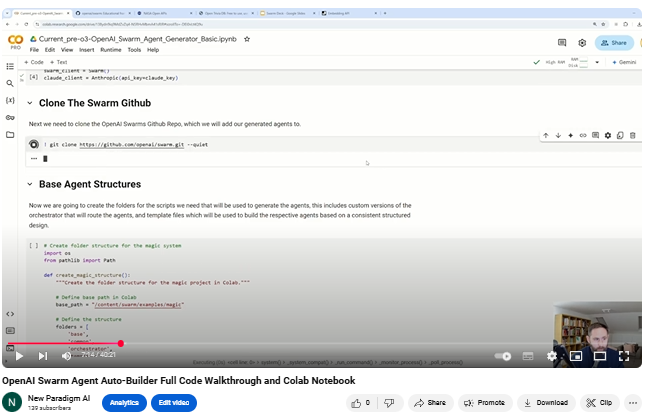

# **Connect with Me**

*   If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/

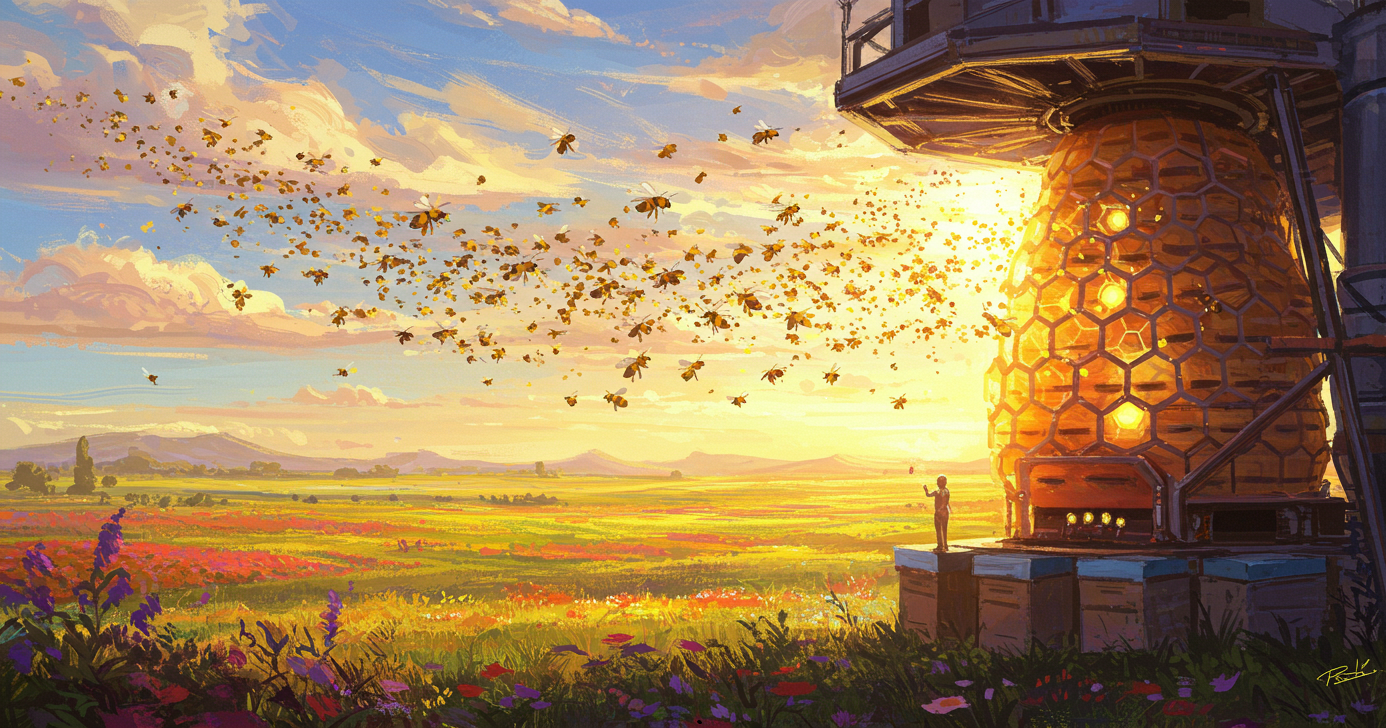

# **For Best Results**

**What You Will Need**

1.   An OpenAI API Key (to run the OpenAI swarms framework and generate agents)
2.   An Anthropic API Key (as an alternative for agent code generation/ fixes)
3.   A Jina API Key

**What To Expect**

I emphasize the experimental nature of this notebook. I find that agent generations for the below examples, and other I have tested usually work for about 80-90% of the time.

How well it performs also depends a lot on your choice of AI model to run the generations (if in doubt to start with use Sonnet 3.5) and the quality of your agent specification (the clearer and more prescriptive the better).

**Watch The Walkthrough**

I highly recommend watching the video walkthough and running the demo examples first before trying to generate your own.

**Update for OpenAI o3-mini**

As of 31st January 2025, I updated this experimental tool to include OpenAI's new o3-mini model series as options for generating agents.


# **If You Like This Please Leave A Github Star and Check Out**

*   My OpenAI agentic swarms basic demos notebook available here: https://github.com/smartaces/openai_agentic_swarms_live_webapi_chat_assistant

*   My OpenAI agentic swarms flight, car salesman, and personal shopper assistant demo notebook here: https://github.com/smartaces/openai_agentic_swarms_live_webapi_chat_assistant/blob/main/Shared_OpenAI_Swarm_Multi_API_Agent_Example.ipynb

# **Step1: Installs OpenAI python library**

First we need to install the OpenAI python Library and respective files from the OpenAI swarms github.

In [ ]:
#installs
!pip install numpy openai>=1.33.0 pytest requests tqdm pre-commit instructor --quiet
!pip install anthropic --quiet
!pip install git+https://github.com/openai/swarm.git --quiet
!pip install gspread --quiet
!pip install python-docx --quiet
!apt-get -qq install subversion --quiet
!pip install PyPDF2 --quiet
!pip install requests pandas ipywidgets --quiet

# **Set Your OpenAI API Key**

To use this notebook and build your solution you will need...


*   An OpenAI user account and API Key (with billing set up)
*   Access to the o1 models (this may or may not be available to you yet)
*   As pictured below add this to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name
*   Key name: openai_key
*   Once that is done, run the below cell[link text granting key access to the notebook access if prompted




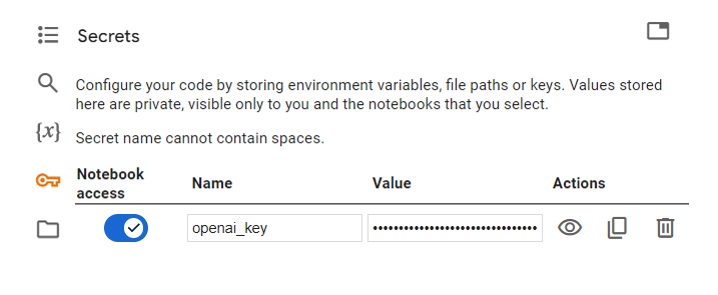


# **Setup Other Keys**

Just like the OpenAI key, you will also need to have the following API keys added to your Google Colab secrets:

*   Your Anthropic Key named as: claude_api
*   Your Jina Key named as: JINA_API

Where to get your Jina Key: https://jina.ai/embeddings/

Where to get your Anthropic Key: https://docs.anthropic.com/en/api/getting-started



In [ ]:
import os
from openai import OpenAI
from google.colab import userdata
from swarm import Swarm, Agent
from anthropic import Anthropic

# Retrieve API keys from Google Colab Secrets
openai_key = userdata.get('openai_key')
claude_key = userdata.get('claude_api')

jina_api_key = userdata.get('JINA_API')
# Set API keys as environment variables
os.environ["OPENAI_API_KEY"] = openai_key
os.environ["ANTHROPIC_API_KEY"] = claude_key
os.environ["JINA_API_KEY"] = jina_api_key

# Initialize clients
swarm_client = Swarm()
claude_client = Anthropic(api_key=claude_key)

#**Clone The Swarm Github**

Next we need to clone the OpenAI Swarms Github Repo, which we will add our generated agents to.

In [ ]:
! git clone https://github.com/openai/swarm.git --quiet

# **Base Agent Structures**

Now we are going to create the folders for the scripts we need that will be used to generate the agents, this includes custom versions of the orchestrator that will route the agents, and template files which will be used to build the respective agents based on a consistent structured design.

In [ ]:
# Create folder structure for the magic system
import os
from pathlib import Path

def create_magic_structure():
    """Create the folder structure for the magic project in Colab."""

    # Define base path in Colab
    base_path = "/content/swarm/examples/magic"

    # Define the structure
    folders = [
        'base',
        'common',
        'orchestrator',
        'templates',
        'templates/agent_template',  # Template for new agents
        'utils',                     # Utility scripts
    ]

    # Create base directory
    base_dir = Path(base_path)
    base_dir.mkdir(parents=True, exist_ok=True)

    # Create all subdirectories
    for folder in folders:
        folder_path = base_dir / folder
        folder_path.mkdir(parents=True, exist_ok=True)

    # Print the created structure with verification
    print(f"\nCreated folder structure at: {base_path}")
    print("\nVerifying structure...")

    # Verify and display the created structure
    for folder in folders:
        path = base_dir / folder
        status = "✓ Created" if path.exists() else "✗ Failed"
        print(f"{status}: {folder}/")

    # Print the full path for reference
    print(f"\nFull path to project: {base_dir.absolute()}")

    return str(base_dir)

# Execute the function
project_path = create_magic_structure()

# **Memory Manager**
This code implements a memory management system in Python, to store and retrieve data for the different types of agents. It uses a dictionary-based structure where data can be organized by agent type and specific keys, with each piece of stored data including a timestamp. The MemoryManager class provides methods to store values, retrieve them, and clear either specific agent data or all stored data. The code creates a global memory_manager instance that can be used across the swarm network.

In [ ]:
# base/memory_manager.py

%%writefile /content/swarm/examples/magic/base/memory_manager.py
from typing import Dict, Set, Any, Optional
from datetime import datetime

class MemoryManager:
    def __init__(self):
        self.memory: Dict[str, Dict[str, Any]] = {}

    def store(self, agent_type: str, key: str, value: Any):
        """Store any type of data for an agent"""
        if agent_type not in self.memory:
            self.memory[agent_type] = {}
        self.memory[agent_type][key] = {
            'value': value,
            'timestamp': datetime.now()
        }

    def retrieve(self, agent_type: str, key: str) -> Optional[Any]:
        """Retrieve data for an agent"""
        return (self.memory.get(agent_type, {})
                .get(key, {})
                .get('value'))

    def clear_agent(self, agent_type: str):
        """Clear all memory for an agent type"""
        if agent_type in self.memory:
            self.memory[agent_type].clear()

    def clear_all(self):
        """Clear all memory"""
        self.memory.clear()

# Initialize global memory
memory_manager = MemoryManager()

# **Common Functions**

This code defines a set of utility functions for managing agent memory and handling common workflow operations. The functions include the ability to reset memory (either for specific agents or all memory), mark cases as resolved, escalate issues to human operators, and transfer cases back to triage. It imports and uses the memory_manager from the base module to handle the memory-related operations.

In [ ]:
# common/functions.py
%%writefile /content/swarm/examples/magic/common/functions.py
from base.memory_manager import memory_manager

def reset_memory(agent_type: str = None):
    """Reset memory for specific agent type or all memory if no type specified."""
    if agent_type:
        memory_manager.clear_agent(agent_type)
        return f"Memory reset for {agent_type}"
    memory_manager.clear_all()
    return "All memory has been reset"

def case_resolved():
    """Generic case resolution."""
    return "Case resolved successfully."

def escalate_to_human():
    """Generic human escalation."""
    return "Escalating to human operator..."

def transfer_to_triage():
    """Generic transfer back to triage."""
    return "Transferring back to triage..."


# **Orchestrator Triage**

This code implements an orchestration system for managing different AI agents. The AgentOrchestrator class automatically discovers, loads, and initializes specialized agents from a directory structure. It creates a main triage agent that can direct user requests to appropriate specialized agents, handle escalations, and manage memory. The system includes dynamic loading of agents through Python's import mechanism and creates transfer functions to allow smooth handoffs between agents. The orchestrator serves as the central coordinator for a multi-agent system, with the triage agent acting as the first point of contact for user interactions.

In [ ]:
# orchestrator/triage.py
%%writefile /content/swarm/examples/magic/orchestrator/triage.py
import sys
import os
from pathlib import Path
from swarm import Agent
from typing import Dict, Callable
import importlib.util

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from common.functions import reset_memory, escalate_to_human

class AgentOrchestrator:
    def __init__(self):
        self.triage_agent = None
        self.specialized_agents: Dict[str, Agent] = {}

    def discover_agents(self, base_path: str = "/content/swarm/examples/magic"):
        """Automatically discover and load agents from the agents directory."""
        base_dir = Path(base_path)
        agents_dir = base_dir / "agents"

        # Add base path and agents path to Python path
        if str(base_dir) not in sys.path:
            sys.path.append(str(base_dir))
        if str(agents_dir) not in sys.path:
            sys.path.append(str(agents_dir))

        # Look for directories in the agents folder that contain agent.py
        if agents_dir.exists():
            for path in agents_dir.iterdir():
                if path.is_dir() and (path / 'agent.py').exists():
                    agent_name = path.name
                    self._load_agent(path, agent_name)
        else:
            print(f"Warning: Agents directory not found at {agents_dir}")

    def _load_agent(self, agent_path: Path, agent_name: str):
        """Load an agent from a given path."""
        try:
            # Import the agent module
            module_name = f"agents.{agent_name}.agent"
            spec = importlib.util.spec_from_file_location(
                module_name,
                str(agent_path / 'agent.py')
            )
            module = importlib.util.module_from_spec(spec)
            sys.modules[module_name] = module
            spec.loader.exec_module(module)

            # Get the create_agent function
            create_func = getattr(module, f"create_{agent_name}_agent")

            # Store the creation function
            self.specialized_agents[agent_name] = create_func
            print(f"Successfully loaded agent: {agent_name}")

        except Exception as e:
            print(f"Failed to load agent from {agent_path}: {e}")
            import traceback
            traceback.print_exc()

    def initialize_agents(self):
        """Initialize all agents and create triage agent."""
        # Create triage agent first
        self.triage_agent = self._create_triage_agent()

        # Initialize all specialized agents with reference to triage
        initialized_agents = {}
        for name, create_func in self.specialized_agents.items():
            try:
                initialized_agents[name] = create_func(self.triage_agent)
                print(f"Successfully initialized agent: {name}")
            except Exception as e:
                print(f"Failed to initialize agent {name}: {e}")
                import traceback
                traceback.print_exc()

        self.specialized_agents = initialized_agents
        return self.triage_agent

    def _create_triage_agent(self):
        """Create the triage agent with dynamic transfer functions."""
        # Create transfer functions for each specialized agent
        transfer_functions = {}

        for agent_name in self.specialized_agents.keys():
            def make_transfer(name=agent_name):
                def transfer_func():
                    return self.specialized_agents[name]
                # Set a valid function name for OpenAI
                transfer_func.__name__ = f"transfer_to_{name}"
                return transfer_func

            transfer_functions[agent_name] = make_transfer()

        # Create instructions with available agents
        agent_list = "\n".join(
            f"- {name.replace('_', ' ').title()} (use transfer_to_{name})"
            for name in self.specialized_agents.keys()
        ) or "No specialized agents currently available."

        # Create functions list with proper names
        functions = [
            transfer_functions[name] for name in self.specialized_agents.keys()
        ]

        # Add standard functions
        reset_memory.__name__ = "reset_memory"
        escalate_to_human.__name__ = "escalate_to_human"

        functions.extend([
            escalate_to_human,
            reset_memory
        ])

        instructions = f"""You are a triage agent. Your job is to:
        1. Understand what type of request the user has
        2. Direct them to the appropriate specialist agent using the transfer functions
        3. Handle any escalations or special requests

        Available specialists:
        {agent_list}
        """

        return Agent(
            name="Magic Triage Agent",
            instructions=instructions,
            functions=functions
        )

def create_orchestrator():
    orchestrator = AgentOrchestrator()
    orchestrator.discover_agents()
    return orchestrator.initialize_agents()

# **Main.py**

This code serves as the main entry point for a multi-agent system. It initializes the orchestration system by creating a triage agent, sets up basic system context variables, and launches an interactive demo loop where users can communicate with the system. The script uses the swarm framework's built-in REPL (Read-Eval-Print Loop) functionality to manage the ongoing conversation between users and agents.

In [ ]:
# main.py
%%writefile /content/swarm/examples/magic/main.py
from swarm.repl import run_demo_loop
from orchestrator.triage import create_orchestrator

def main():
    # Create and initialize the orchestrator which returns the triage agent
    triage_agent = create_orchestrator()

    # Setup context
    context_variables = {
        "system_context": """
        System Status: Active
        Allowed Operations: All
        Previous Interactions: None
        """
    }

    # Run the conversation loop
    run_demo_loop(triage_agent, context_variables=context_variables, debug=False)

if __name__ == "__main__":
    main()


# **Agent Loader**

This code provides utility functions for creating new agents from templates in a multi-agent system. The agent_loader.py module includes two main functions: load_template() which handles loading and customizing template files with replacements, and create_agent_files() which generates a new agent's file structure with customized content, functions, and logic based on provided templates. It automates the process of setting up new agents with consistent structure and formatting.

In [ ]:
# utils/agent_loader.py
%%writefile /content/swarm/examples/magic/utils/agent_loader.py
from pathlib import Path
import shutil
import os

def load_template(template_path: str, replacements: dict) -> str:
    """Load a template file and apply replacements."""
    with open(template_path, 'r') as f:
        content = f.read()

    for key, value in replacements.items():
        content = content.replace(f"${key}$", value)

    return content

def create_agent_files(
    agent_name: str,
    content_definition: str,
    function_name: str,
    function_logic: str,
    return_value: str,
    base_path: str = "/content/swarm/examples/magic",
    template_path: str = "/content/swarm/examples/magic/templates/agent_template"
):
    """
    Create a new agent from templates.

    Args:
        agent_name: Name of the new agent (e.g., "Data Processor")
        content_definition: The content to include in content.py
        function_name: The primary function name (e.g., "process_data")
        function_logic: The logic inside the primary function
        return_value: What the function returns
        base_path: Base path where the agent should be created
        template_path: Path to the template files
    """
    # Convert agent name to snake_case for folder and variable naming
    agent_type = agent_name.lower().replace(' ', '_')
    content_variable = agent_type.upper()

    # Create paths
    template_dir = Path(template_path)
    new_agent_dir = Path(base_path) / "agents" / agent_type

    # Check if agent already exists
    if new_agent_dir.exists():
        print(f"Agent '{agent_name}' already exists at {new_agent_dir}")
        return

    # Create agent directory
    new_agent_dir.mkdir(parents=True, exist_ok=True)

    # Define replacements
    replacements = {
        'AGENT_NAME': agent_name,
        'AGENT_TYPE': agent_type,
        'CONTENT_VARIABLE': content_variable,
        'FUNCTION_NAME': function_name
    }

    # Process each template file
    for template_file in template_dir.glob('*'):
        if template_file.suffix == '.py':
            content = load_template(str(template_file), replacements)

            # Handle specific placeholders based on file name
            if template_file.name == 'content.py':
                content = content.replace('$CONTENT_DEFINITION$', content_definition)
            elif template_file.name == 'functions.py':
                content = content.replace('$FUNCTION_LOGIC$', function_logic)
                content = content.replace('$RETURN_VALUE$', return_value)

            # Create new file
            new_file = new_agent_dir / template_file.name
            with open(new_file, 'w') as f:
                f.write(content)

    # Create __init__.py
    init_file = new_agent_dir / '__init__.py'
    with open(init_file, 'w') as f:
        f.write(f"# Initialize the {agent_name} agent package\n")

    print(f"Agent '{agent_name}' created successfully at {new_agent_dir}")
    return str(new_agent_dir)


# **Make the Agent Directory**

This command creates a directory called 'agents' and any necessary parent directories within the '/content/swarm/examples/magic/' path. The -p flag ensures all required parent directories are created if they don't already exist.

In [ ]:
!mkdir -p /content/swarm/examples/magic/agents

**------------------------------------------**

# **First Let's Make A Simple Knock Knock Joke Agent Manually** 🤚

*   Before we jump into the automatic agent generator, let's just make a simple swarm agent, so you can see how all the template files are used and stitch together.

*   This helps to understand the basic script/ file structure of our agents.

**------------------------------------------**

# **Manual Agent Creation Example Using The Templates**



# **Knock Knock Joke Agent**

First Let's make the agent directory, where all the scripts and information powering the agent are stored, and the init file.

In [ ]:
!mkdir -p /content/swarm/examples/magic/agents/knock_knock

In [ ]:
# Create the init file
%%writefile /content/swarm/examples/magic/agents/knock_knock/__init__.py

# **Content.py**

Next let's create the content.py file, in this case because we are making a knock knock joke agent, it contains... well... knock knock jokes.

The jokes are stored in the KNOCK_KNOCK_JOKES variable which can be imported and used by the agent in its conversations with the user.

In this case we are using static information, but as we will see later, we can also use dynamic live information from internet APIs.

In [ ]:
# knock_knock/content.py
%%writefile /content/swarm/examples/magic/agents/knock_knock/content.py
"""
Content file for knock knock jokes agent
"""
KNOCK_KNOCK_JOKES = [
    {"setup": "Knock knock!", "who": "Interrupting cow", "punchline": "MOO!"},
    {"setup": "Knock knock!", "who": "Letter", "punchline": "Letter in, it's cold out here!"},
    {"setup": "Knock knock!", "who": "Tank", "punchline": "You're welcome!"},
    {"setup": "Knock knock!", "who": "Boo", "punchline": "Don't cry, it's just a joke!"},
    {"setup": "Knock knock!", "who": "Orange", "punchline": "Orange you glad I didn't say banana?"}
]


# **Functions.py**

This function file defines core behaviors for the agent, providing a main operational function that selects content from an imported content pool (in this case jokes). It utilizes a memory manager system to track what content has been previously selected, preventing repetition until all options have been used, at which point it resets. The file includes necessary imports and path configurations to ensure the agent can access required system resources and content.

In [ ]:
# knock_knock/functions.py
%%writefile /content/swarm/examples/magic/agents/knock_knock/functions.py
"""
Functions for the knock knock jokes agent
"""
import random
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from base.memory_manager import memory_manager
from agents.knock_knock.content import KNOCK_KNOCK_JOKES

def tell_knock_joke():
    """
    Select and return a knock knock joke that hasn't been told recently
    """
    # Get all jokes that haven't been told
    available_jokes = [joke for joke in KNOCK_KNOCK_JOKES
                      if not memory_manager.retrieve('knock_knock', str(joke))]

    # If all jokes have been told, reset memory
    if not available_jokes:
        memory_manager.clear_agent('knock_knock')
        available_jokes = KNOCK_KNOCK_JOKES

    # Select and mark joke as told
    chosen_joke = random.choice(available_jokes)
    memory_manager.store('knock_knock', str(chosen_joke), True)

    return chosen_joke

# **Agent.py**

This agent file serves as the definition and configuration file for a specialized agent. It creates the agent by:

*   Setting up required imports
*   Defining a creation function that configures how the agent works (including how it transfers back to triage)
*   Setting up correctly named function hooks that the agent can use
*   Creating and returning an Agent instance with specific instructions and access to its operational functions

The instructions define exactly how the agent should behave, what steps it should follow, and what functions it has available to use.
This is basically a blueprint file that tells the system how to construct and operate this particular type of specialized agent.

In [ ]:
# knock_knock/agent.py
%%writefile /content/swarm/examples/magic/agents/knock_knock/agent.py
"""
Knock knock jokes specialist agent
"""
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from swarm import Agent
from agents.knock_knock.functions import tell_knock_joke
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_knock_knock_agent(triage_agent):
    """
    Create a knock knock jokes specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    tell_knock_joke.__name__ = "tell_knock_knock_joke"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_knock_knock():
        return reset_memory('knock_knock')
    reset_knock_knock.__name__ = "reset_knock_knock"

    return Agent(
        name="Knock Knock Jokes Specialist",
        instructions="""You are a knock knock joke specialist. Your job is to:
        1. Get a new knock knock joke using tell_knock_knock_joke
        2. Present the setup ("Knock knock!")
        3. Wait for the user to say "who's there?"
        4. Present the "who" part and wait for the user's response
        5. Deliver the punchline
        6. If they want another joke, tell another one
        7. If they want a different type of joke, use transfer_to_triage
        8. If they're done, call case_resolved

        IMPORTANT: You can ONLY tell knock knock jokes. For any other requests,
        transfer the user back to triage using transfer_to_triage.""",
        functions=[
            tell_knock_joke,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_knock_knock
        ]
    )

# **Now Let's Talk To Our Knock Knock Joke Agent...**

# **Some Visual Formatting...**

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# **Run The Agent by Loading The Main.py**

In [ ]:
!python /content/swarm/examples/magic/main.py

**-----------------------------------------------**

# **Load In Some Agents From The GitHub Repo**

I have prepared a few basic agents you can also just load in from my github repo...

In [ ]:
# @title **GitHub Folder Browser and Downloader**
from IPython.display import clear_output
import ipywidgets as widgets

def list_folders():
    !rm -rf /tmp/test_clone
    !mkdir -p /tmp/test_clone
    %cd /tmp/test_clone
    !git clone --depth 1 --quiet https://github.com/smartaces/OpenAI_Swarms_Agent_AutoBuilder.git
    %cd OpenAI_Swarms_Agent_AutoBuilder

    import os
    folders = [d for d in os.listdir() if os.path.isdir(d) and not d.startswith('.')]

    %cd /content
    !rm -rf /tmp/test_clone
    return folders

def download_selected_folder(folder_name):
    clear_output()
    print(f"Downloading {folder_name}...")

    !mkdir -p /tmp/sparse_clone
    %cd /tmp/sparse_clone
    !git init --quiet
    !git remote add origin https://github.com/smartaces/OpenAI_Swarms_Agent_AutoBuilder.git
    !git config core.sparseCheckout true
    !echo "{folder_name}/*" > .git/info/sparse-checkout
    !git pull --quiet origin main
    !cp -r {folder_name} /content/swarm/examples/magic/agents/
    %cd /content
    !rm -rf /tmp/sparse_clone

    print(f"✓ Downloaded to /content/swarm/examples/magic/agents/")

# Create cleaner UI elements
folders = list_folders()
folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Folder:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

download_button = widgets.Button(
    description="Download",
    layout={'width': '100px'}
)

output = widgets.Output(layout={'width': 'auto', 'height': '50px'})

def on_download_clicked(b):
    with output:
        clear_output()
        if folder_dropdown.value:
            download_selected_folder(folder_dropdown.value)

download_button.on_click(on_download_clicked)

# Display compact interface
display(widgets.HBox([folder_dropdown, download_button]))
display(output)

**-----------------------------------------------**

# **Agent Generator Scripts** 🤖

Now we know what a basic agent looks like, and what it is composed of, we are going to add blank templates that will form the basis of each of the components of the agent, namely...

*   content.py
*   agent.py
*   functions.py

**-----------------------------------------------**

# **Template Files Creation**

These are structured templates, that our agent builder will use to build consistently defined and designed agents, but flexible enough to adapt to a breadth of purposes.

# **Blank Content.py Agent Template**

This a template file used for generating agent-specific content. It contains placeholder variables (AGENT_NAME and CONTENT_DEFINITION) that would be replaced with actual values when the template is used to create new agent content files. The template allows for storing different types of content like FAQs, data, or instructions that would be specific to each particular agent being created.

In [ ]:
%%writefile /content/swarm/examples/magic/templates/agent_template/content.py
"""
Content file for $AGENT_NAME$ agent
"""
# Define the content specific to the $AGENT_NAME$ agent
# This could be FAQs, data entries, instructions, or any relevant information

$CONTENT_DEFINITION$


# **Blank Agent.py Template**

This is used to generate agent definition files. It provides a standard structure that gets customized when creating new specialized agents. The file uses placeholder variables (marked with VARIABLE) that get replaced with specific values when a new agent is created. It includes:

*   Basic imports and path configuration
*   A creation function that sets up the agent
*   Function name configurations
*   A reset function definition
*   A standardized Agent instance return with customizable name, instructions, and function list

This template ensures all agents are created with consistent structure and functionality while allowing for customization of the specific agent's purpose and capabilities.



In [ ]:
%%writefile /content/swarm/examples/magic/templates/agent_template/agent.py
"""
$AGENT_NAME$ specialist agent
"""
import sys
import os

# Add the base directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from swarm import Agent
from agents.$AGENT_TYPE$.functions import $FUNCTION_NAME$
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_${AGENT_TYPE}_agent(triage_agent):
    """
    Create a $AGENT_NAME$ specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    $FUNCTION_NAME$.__name__ = "$FUNCTION_NAME$"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_${AGENT_TYPE}():
        return reset_memory('$AGENT_TYPE$')
    reset_${AGENT_TYPE}.__name__ = "reset_${AGENT_TYPE}"

    return Agent(
        name="$AGENT_NAME$ Specialist",
        instructions=\"""You are a $AGENT_NAME$ specialist. Your job is to:
        1. Perform the primary function using the $FUNCTION_NAME$ function
        2. If the user requests, perform additional tasks
        3. If the task is completed, call case_resolved
        4. If assistance is needed, use escalate_to_human
        5. If transferring back to triage, use transfer_to_triage

        IMPORTANT: You can ONLY perform $AGENT_NAME$ related tasks. For any other requests,
        transfer the user back to triage using transfer_to_triage.\""",
        functions=[
            $FUNCTION_NAME$,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_${AGENT_TYPE}
        ]
    )


# **Init File Creation**

Just run this :) it is needed.

In [ ]:
%%writefile /content/swarm/examples/magic/templates/agent_template/__init__.py
# Initialize the $AGENT_NAME$ agent package


# **Blank Functions.py Template**

This creates the functions file for new specialized agents. It provides a standardized structure with placeholder variables (VARIABLE) that get replaced when generating a new agent's function file. The template includes:

*   Required imports and path setup
*   Memory manager import for state tracking
*   Content import specific to the agent type
*   A placeholder for the main function definition with customizable logic and return value

This template ensures consistent function file structure across different agent types while allowing customization of the specific functionality each agent needs to perform.

In [ ]:
# @title
%%writefile /content/swarm/examples/magic/templates/agent_template/functions.py
"""
Functions for the $AGENT_NAME$ agent
"""
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from base.memory_manager import memory_manager
from agents.$AGENT_TYPE$.content import $CONTENT_VARIABLE$

def $FUNCTION_NAME$():
    """
    Description of what $FUNCTION_NAME$ does.
    """
    # Implement the function's logic here
    $FUNCTION_LOGIC$

    return $RETURN_VALUE$


**-----------------------------------------------**

# **Agent API Docs and Specifications Setup**

Now our templates are in place, we can proceed to setting up the specification of our agent, and providing information that helps the agent-generator successfully build and agent. This consists of a few things...

*   *API docs*: If you are building an agent that uses an API for calling information, the builder will need information on the connection it needs to build. This is pretty much as simple as copy-pasting a page of the documentation

*   *Examples of agents*: I have supplied these already, they act as a form of few-shot prompting to help the builder stay on track with the build

*   *Agent description*: So this will work in two steps, there is an auto-specification writer, which uses AI to generate a specification document from the API information you provide, or simple instructions.


**-----------------------------------------------**

# **Demo API Texts for Your Agents** 📑

*   Simply run the next cell to load in some example API specification text docs. If you want to try and build one of the example agents, you can simple copy paste the text from the .txt, these include a foreign exchange rate agent, a nasa agent, a trivia quiz agent and a cocktail recipe maker agent.



In [ ]:
# @title
import os

# Define the target directory
save_dir = "/content/swarm/examples/magic/"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Define the file contents
files_content = {
    "arxiv_api.txt": """2. API QuickStart
The easiest place to start with the API is by accessing it through a web browser. For examples of accessing the API through common programming languages, see the Examples section.

Most everyone that has read or submitted e-prints on the arXiv is familiar with the arXiv human web interface. These HTML pages can be accessed by opening up your web browser, and entering the following url in your web browser

http://arxiv.org

From there, the article listings can be browsed by clicking on one of the many links, or you can search for articles using the search box in the upper right hand side of the page. For example, if I wanted to search for articles that contain the word electron in the title or abstract, I would type electron in the search box, and click Go. If you follow my example, you will see something like this: a web page listing the title and authors of each result, with links to the abstract page, pdf, etc.

In its simplest form, the API can be used in exactly the same way. However, it uses a few shortcuts so there is less clicking involved. For example, you can see the same search results for electron by entering the url

http://export.arxiv.org/api/query?search_query=all:electron.

Alternatively, you can search for articles that contain electron AND proton with the API by entering

http://export.arxiv.org/api/query?search_query=all:electron+AND+all:proton

What you see will look different from the HTML interface, but it contains the same information as the search done with the human interface. The reason why the results look different is that the API returns results in the Atom 1.0 format, and not HTML. Since Atom is defined as an XML grammar, it is much easier to digest for programs than HTML. The API is not intended to be used inside a web browser by itself, but this is a particularly simple way to debug a program that does use the API.

You might notice that your web browser has asked you if you want to “subscribe to this feed” after you enter the API url. This is because Atom is one of the formats used by web sites to syndicate their content. These feeds are usually read with feed reader software, and are what is generated by the existing arXiv rss feeds. The current arXiv feeds only give you updates on new papers within the category you specify. One immediately useful thing to do with the API then is to generate your own feed, based on a custom query!

To learn more about how to construct custom search queries with the API, see the appendix on the details of query construction. To learn about what information is returned by the API, see the section on the API response. To learn more about writing programs to call the API, and digest the responses, we suggest starting with the section on Structure of the API.

3.1. Calling the API
As mentioned above, the API can be called with an HTTP request of type GET or POST. For our purposes, the main difference is that the parameters are included in the url for a GET request, but not for the POST request. Thus if the parameters list is unusually long, a POST request might be preferred.

The parameters for each of the API methods are explained below. For each method, the base url is


http://export.arxiv.org/api/{method_name}?{parameters}

3.1.1. Query Interface
The API query interface has method_name=query. The table below outlines the parameters that can be passed to the query interface. Parameters are separated with the & sign in the constructed url's.

query
parameters	type	defaults	required
search_query	string	None	No
id_list	comma-delimited string	None	No
start	int	0	No
max_results	int	10	No

3.1.1.1. search_query and id_list logic
We have already seen the use of search_query in the quickstart section. The search_query takes a string that represents a search query used to find articles. The construction of search_query is described in the search query construction appendix. The id_list contains a comma-delimited list of arXiv id's.

The logic of these two parameters is as follows:

If only search_query is given (id_list is blank or not given), then the API will return results for each article that matches the search query.

If only id_list is given (search_query is blank or not given), then the API will return results for each article in id_list.

If BOTH search_query and id_list are given, then the API will return each article in id_list that matches search_query. This allows the API to act as a results filter.

This is summarized in the following table:

search_query present	id_list present	API returns
yes	no	articles that match search_query
no	yes	articles that are in id_list
yes	yes	articles in id_list that also match search_query

3.1.1.2. start and max_results paging
Many times there are hundreds of results for an API query. Rather than download information about all the results at once, the API offers a paging mechanism through start and max_results that allows you to download chucks of the result set at a time. Within the total results set, start defines the index of the first returned result, using 0-based indexing. max_results is the number of results returned by the query. For example, if wanted to step through the results of a search_query of all:electron, we would construct the urls:


http://export.arxiv.org/api/query?search_query=all:electron&start=0&max_results=10 (1)
http://export.arxiv.org/api/query?search_query=all:electron&start=10&max_results=10 (2)
http://export.arxiv.org/api/query?search_query=all:electron&start=20&max_results=10 (3)
Get results 0-9

Get results 10-19

Get results 20-29

Detailed examples of how to perform paging in a variety of programming languages can be found in the examples section.

In cases where the API needs to be called multiple times in a row, we encourage you to play nice and incorporate a 3 second delay in your code. The detailed examples below illustrate how to do this in a variety of languages.

Because of speed limitations in our implementation of the API, the maximum number of results returned from a single call (max_results) is limited to 30000 in slices of at most 2000 at a time, using the max_results and start query parameters. For example to retrieve matches 6001-8000: http://export.arxiv.org/api/query?search_query=all:electron&start=6000&max_results=2000

Large result sets put considerable load on the server and also take a long time to render. We recommend to refine queries which return more than 1,000 results, or at least request smaller slices. For bulk metadata harvesting or set information, etc., the OAI-PMH interface is more suitable. A request with max_results >30,000 will result in an HTTP 400 error code with appropriate explanation. A request for 30000 results will typically take a little over 2 minutes to return a response of over 15MB. Requests for fewer results are much faster and correspondingly smaller.


3.1.1.3. sort order for return results
There are two options for for the result set to the API search, sortBy and sortOrder.

sortBy can be "relevance", "lastUpdatedDate", "submittedDate"

sortOrder can be either "ascending" or "descending"

A sample query using these new parameters looks like:


http://export.arxiv.org/api/query?search_query=ti:"electron thermal conductivity"&sortBy=lastUpdatedDate&sortOrder=ascending

3.2. The API Response
Everything returned by the API in the body of the HTTP responses is Atom 1.0, including errors. Atom is a grammar of XML that is popular in the world of content syndication, and is very similar to RSS for this purpose. Typically web sites with dynamic content such as news sites and blogs will publish their content as Atom or RSS feeds. However, Atom is a general format that embodies the concept of a list of items, and thus is well-suited to returning the arXiv search results.


3.3. Outline of an Atom feed
In this section we will discuss the contents of the Atom documents returned by the API. To see the full explanation of the Atom 1.0 format, please see the Atom specification.

An API response consists of an Atom <feed> element which contains metadata about the API call performed, as well as child <entry> elements which embody the metadata for each of the returned results. Below we explain each of the elements and attributes. We will base our discussion on the sample results feed discussed in the examples section.

You may notice that the results from the API are ordered differently that the results given by the HTML arXiv search interface. The HTML interface automatically sorts results in descending order based on the date of their submission, while the API returns results according to relevancy from the internal search engine. Thus when debugging a search query, we encourage you to use the API within a web browser, rather than the HTML search interface. If you want sorting by date, you can always do this within your programs by reading the <published> tag for each entry as explained below.


3.3.1. Feed Metadata
Every response will contain the line:


<?xml version="1.0" encoding="utf-8"?>
to signify that we are receiving XML 1.0 with a UTF-8 encoding. Following that line will be a line indicating that we are receiving an Atom feed:


<feed xmlns="http://www.w3.org/2005/Atom"
xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/"
xmlns:arxiv="http://arxiv.org/schemas/atom">
You will notice that three XML namespaces are defined. The default namespace signifies that we are dealing with Atom 1.0. The other two namespaces define extensions to Atom that we describe below.


3.3.1.1. <title>, <id>, <link> and <updated>
The <title> element gives the title for the feed:


<title xmlns="http://www.w3.org/2005/Atom">
    ArXiv Query:  search_query=all:electron&amp;id_list=&amp;start=0&amp;max_results=1
</title>
The title contains a canonicalized version of the query used to call the API. The canonicalization includes all parameters, using their defaults if they were not included, and always puts them in the order search_query,id_list,start,max_results, even if they were specified in a different order in the actual query.

The <id> element serves as a unique id for this query, and is useful if you are writing a program such as a feed reader that wants to keep track of all the feeds requested in the past. This id can then be used as a key in a database.


<id xmlns="http://www.w3.org/2005/Atom">
    http://arxiv.org/api/cHxbiOdZaP56ODnBPIenZhzg5f8
</id>
The id is guaranteed to be unique for each query.

The <link> element provides a URL that can be used to retrieve this feed again.


<link xmlns="http://www.w3.org/2005/Atom" href="http://arxiv.org/api/query?search_query=all:electron&amp;id_list=&amp;start=0&amp;max_results=1" rel="self" type="application/atom+xml"/>
Note that the url in the link represents the canonicalized version of the query. The <link>

OpenSearch is a lightweight technology that acts in a similar way as the Web Services Description Language. The OpenSearch elements we have included allow OpenSearch enabled clients to digest our results. Such clients often include search result aggregators and browser pluggins that allow searching from a variety of sources.

The OpenSearch extension elements can still be useful to you even if you are not writing one of these applications. The <opensearch:totalResults> element lists how many results are in the result set for the query:


<opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">
   1000
</opensearch:totalResults>
This can be very useful when implementing paging of search results. The other two elements <opensearch:startIndex>, and <opensearch:itemsPerPage> are analogous to start, and max_results discussed above.


<opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">
   0
</opensearch:startIndex>
<opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">
   1
</opensearch:itemsPerPage>

3.3.2. Entry Metadata
If there are no errors, the <feed> element contains 0 or more child <entry> elements with each <entry> representing an article in the returned results set. As explained in the errors section, if there are errors, a single <entry> element representing the error is returned. Below the element description describes the elements for <entry>'s representing arXiv articles. For a general discussion of arXiv metadata, see the arXiv metadata explanation.


3.3.2.1. <title>, <id>, <published>, and <updated>
The <title> element contains the title of the article returned:


<title xmlns="http://www.w3.org/2005/Atom">
    Multi-Electron Production at High Transverse Momenta in ep Collisions at HERA
</title>
The <id> element contains a url that resolves to the abstract page for that article:


<id xmlns="http://www.w3.org/2005/Atom">
    http://arxiv.org/abs/hep-ex/0307015
</id>
If you want only the arXiv id for the article, you can remove the leading http://arxiv.org/abs/ in the <id>.

The <published> tag contains the date in which the first version of this article was submitted and processed. The <updated> element contains the date on which the retrieved article was submitted and processed. If the version is version 1, then <published> == <updated>, otherwise they are different. In the example below, the article retrieved was version 2, so <updated> and <published> are different (see the original query).


<published xmlns="http://www.w3.org/2005/Atom">
    2007-02-27T16:02:02-05:00
</published>
<updated xmlns="http://www.w3.org/2005/Atom">
    2007-06-25T17:09:59-04:00
</updated>

3.3.2.2. <summary>, <author> and <category>
The <summary> element contains the abstract for the article:


<summary xmlns="http://www.w3.org/2005/Atom">
    Multi-electron production is studied at high electron transverse momentum
    in positron- and electron-proton collisions using the H1 detector at HERA.
    The data correspond to an integrated luminosity of 115 pb-1. Di-electron
    and tri-electron event yields are measured. Cross sections are derived in
    a restricted phase space region dominated by photon-photon collisions. In
    general good agreement is found with the Standard Model predictions.
    However, for electron pair invariant masses above 100 GeV, three
    di-electron events and three tri-electron events are observed, compared to
    Standard Model expectations of 0.30 \pm 0.04 and 0.23 \pm 0.04,
    respectively.
</summary>
There is one <author> element for each author of the paper in order of authorship. Each <author> element has a <name> sub-element which contains the name of the author.


<author xmlns="http://www.w3.org/2005/Atom">
      <name xmlns="http://www.w3.org/2005/Atom">H1 Collaboration</name>
</author>
If author affiliation is present, it is included as an <arxiv:affiliation> subelement of the <author> element as discussed below.

The <category> element is used to describe either an arXiv, ACM, or MSC classification. See the arXiv metadata explanation for more details about these classifications. The <category> element has two attributes, scheme, which is the categorization scheme, and term which is the term used in the categorization. Here is an example from the query http://export.arxiv.org/api/query?id_list=cs/9901002v1


<category xmlns="http://www.w3.org/2005/Atom" term="cs.LG" scheme="http://arxiv.org/schemas/atom"/>
<category xmlns="http://www.w3.org/2005/Atom" term="cs.AI" scheme="http://arxiv.org/schemas/atom"/>
<category xmlns="http://www.w3.org/2005/Atom" term="I.2.6" scheme="http://arxiv.org/schemas/atom"/>
Note that in this example, there are 3 category elements, one for each category. The first two correspond to arXiv categories, and the last one to an ACM category. See <arxiv> extension elements below for information on how to identify the arXiv primary category.


3.3.2.3. <link>'s
For each entry, there are up to three <link> elements, distinguished by their rel and title attributes. The table below summarizes what these links refer to

rel	title	refers to	always present
alternate	-	abstract page	yes
related	pdf	pdf	yes
related	doi	resolved doi	no
For example:


<link xmlns="http://www.w3.org/2005/Atom" href="http://arxiv.org/abs/hep-ex/0307015v1" rel="alternate" type="text/html"/>
<link xmlns="http://www.w3.org/2005/Atom" title="pdf" href="http://arxiv.org/pdf/hep-ex/0307015v1" rel="related" type="application/pdf"/>
<link xmlns="http://www.w3.org/2005/Atom" title="doi" href="http://dx.doi.org/10.1529/biophysj.104.047340" rel="related"/>

3.3.2.4. <arxiv> extension elements
There are several pieces of arXiv metadata that are not able to be mapped onto the standard Atom specification. We have therefore defined several extension elements which live in the arxiv namespace


http://arxiv.org/schemas/atom
The arXiv classification system supports multiple <category> tags, as well as a primary classification. The primary classification is a replica of an Atom <category> tag, except it has the name <arxiv:primary_category>. For example, from the query http://export.arxiv.org/api/query?id_list=cs/9901002v1, we have


<arxiv:primary_category xmlns:arxiv="http://arxiv.org/schemas/atom" term="cs.LG" scheme="http://arxiv.org/schemas/atom"/>
signifying that cs.LG is the primary arXiv classification for this e-print.

The <arxiv:comment> element contains the typical author comments found on most arXiv articles:


<arxiv:comment xmlns:arxiv="http://arxiv.org/schemas/atom">
   23 pages, 8 figures and 4 tables
</arxiv:comment>
If the author has supplied affiliation information, then this is included as an <arxiv:affiliation> subelement of the standard Atom <author> element. For example, from the query http://export.arxiv.org/api/query?id_list=0710.5765v1, we have


<author>
   <name>G. G. Kacprzak</name>
   <arxiv:affiliation xmlns:arxiv="http://arxiv.org/schemas/atom">NMSU</arxiv:affiliation>
</author>
If the author has provided a journal reference for the article, then there will be a <arxiv:journal_ref> element with this information:


<arxiv:journal_ref xmlns:arxiv="http://arxiv.org/schemas/atom">
   Eur.Phys.J. C31 (2003) 17-29
</arxiv:journal_ref>
If the author has provided a DOI for the article, then there will be a <arxiv:doi> element with this information:


<arxiv:doi xmlns:arxiv="http://arxiv.org/schemas/atom">
   10.1529/biophysj.104.047340
</arxiv:doi>

3.4. Errors
Errors are returned as Atom feeds with a single entry representing the error. The <summary> for the error contains a helpful error message, and the <link> element contains a url to a more detailed explanation of the message.

For example, the API call http://export.arxiv.org/api/query?id_list=1234.12345 contains a malformed id, and results in the error


<?xml version="1.0" encoding="utf-8"?>
<feed xmlns="http://www.w3.org/2005/Atom" xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">
  <link xmlns="http://www.w3.org/2005/Atom" href="http://arxiv.org/api/query?search_query=&amp;id_list=1234.12345" rel="self" type="application/atom+xml"/>
  <title xmlns="http://www.w3.org/2005/Atom">ArXiv Query: search_query=&amp;id_list=1234.12345</title>
  <id xmlns="http://www.w3.org/2005/Atom">http://arxiv.org/api/kvuntZ8c9a4Eq5CF7KY03nMug+Q</id>
  <updated xmlns="http://www.w3.org/2005/Atom">2007-10-12T00:00:00-04:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">1</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>

  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">1</opensearch:itemsPerPage>
  <entry xmlns="http://www.w3.org/2005/Atom">
    <id xmlns="http://www.w3.org/2005/Atom">http://arxiv.org/api/errors#incorrect_id_format_for_1234.12345</id>
    <title xmlns="http://www.w3.org/2005/Atom">Error</title>
    <summary xmlns="http://www.w3.org/2005/Atom">incorrect id format for 1234.12345</summary>
    <updated xmlns="http://www.w3.org/2005/Atom">2007-10-12T00:00:00-04:00</updated>

    <link xmlns="http://www.w3.org/2005/Atom" href="http://arxiv.org/api/errors#incorrect_id_format_for_1234.12345" rel="alternate" type="text/html"/>
    <author xmlns="http://www.w3.org/2005/Atom">
      <name xmlns="http://www.w3.org/2005/Atom">arXiv api core</name>
    </author>
  </entry>
</feed>
The following table gives information on errors that might occur.

Sample query	Error Explanation
http://export.arxiv.org/api/query?start=not_an_int	start must be an integer
http://export.arxiv.org/api/query?start=-1	start must be >= 0
http://export.arxiv.org/api/query?max_results=not_an_int	max_results must be an integer
http://export.arxiv.org/api/query?max_results=-1	max_results must be >= 0
http://export.arxiv.org/api/query?id_list=1234.1234	malformed id - see arxiv identifier explanation
http://export.arxiv.org/api/query?id_list=cond—mat/0709123	malformed id - see arxiv identifier explanation

4.1.2. Python
The urllib module is part of the python standard library, and is included in any default installation of python. Sample code to produce the above output in Python 2.7 is:


    import urllib
    url = 'http://export.arxiv.org/api/query?search_query=all:electron&start=0&max_results=1'
    data = urllib.urlopen(url).read()
    print data
wheras in Python 3 an example would be:


    import urllib.request as libreq
    with libreq.urlopen('http://export.arxiv.org/api/query?search_query=all:electron&start=0&max_results=1') as url:
      r = url.read()
    print(r)""",
    "cocktail_api.txt": """ Free Cocktail API Support
The API and site will always remain free to access at its basic level.

 Test API Key
You can use the test API key "1" during development of your app or for educational use (see test links below)
However you must sign up to Premium API if you want a production API key if releasing publicly on an appstore.

V1 API
 API Methods using the developer test key '1' in the URL

Search cocktail by name
www.thecocktaildb.com/api/json/v1/1/search.php?s=margarita

List all cocktails by first letter
www.thecocktaildb.com/api/json/v1/1/search.php?f=a

Search ingredient by name
www.thecocktaildb.com/api/json/v1/1/search.php?i=vodka

Lookup full cocktail details by id
www.thecocktaildb.com/api/json/v1/1/lookup.php?i=11007

Lookup ingredient by ID
www.thecocktaildb.com/api/json/v1/1/lookup.php?iid=552

Lookup a random cocktail
www.thecocktaildb.com/api/json/v1/1/random.php

Lookup a selection of 10 random cocktails *Premium API only
www.thecocktaildb.com/api/json/v1/1/randomselection.php

List Popular cocktails *Premium API only
www.thecocktaildb.com/api/json/v1/1/popular.php

List most latest cocktails *Premium API only
www.thecocktaildb.com/api/json/v1/1/latest.php

Search by ingredient
www.thecocktaildb.com/api/json/v1/1/filter.php?i=Gin
www.thecocktaildb.com/api/json/v1/1/filter.php?i=Vodka

Filter by multi-ingredient *Premium API only
www.thecocktaildb.com/api/json/v1/1/filter.php?i=Dry_Vermouth,Gin,Anis

Filter by alcoholic
www.thecocktaildb.com/api/json/v1/1/filter.php?a=Alcoholic
www.thecocktaildb.com/api/json/v1/1/filter.php?a=Non_Alcoholic

Filter by Category
www.thecocktaildb.com/api/json/v1/1/filter.php?c=Ordinary_Drink
www.thecocktaildb.com/api/json/v1/1/filter.php?c=Cocktail

Filter by Glass
www.thecocktaildb.com/api/json/v1/1/filter.php?g=Cocktail_glass
www.thecocktaildb.com/api/json/v1/1/filter.php?g=Champagne_flute

List the categories, glasses, ingredients or alcoholic filters
www.thecocktaildb.com/api/json/v1/1/list.php?c=list
www.thecocktaildb.com/api/json/v1/1/list.php?g=list
www.thecocktaildb.com/api/json/v1/1/list.php?i=list
www.thecocktaildb.com/api/json/v1/1/list.php?a=list


 Images
Drink thumbnails
Add /preview to the end of the cocktail image URL
/images/media/drink/vrwquq1478252802.jpg/preview (100x100 pixels)


Ingredient Thumbnails
www.thecocktaildb.com/images/ingredients/gin-Small.png
(100x100 pixels)
www.thecocktaildb.com/images/ingredients/gin-Medium.png
(350x350 pixels)
www.thecocktaildb.com/images/ingredients/gin.png
(700x700 pixels)""",
    "forex_api.txt": """Free Currency Exchange Rates API


Publish-Currencies

Features:
Free & Blazing Fast response
No Rate limits
200+ Currencies, Including Common Cryptocurrencies & Metals
Daily Updated
URL Structure:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@{date}/{apiVersion}/{endpoint}

Formats:
date

The date should either be latest or in YYYY-MM-DD format

The Endpoints Supports HTTP GET Method and returns the data in two formats:

/{endpoint}.json

/{endpoint}.min.json

Endpoints:
/currencies
Lists all the available currencies in prettified json format:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies.json

Get a minified version of it:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies.min.json

/currencies/{currencyCode}
Get the currency list with EUR as base currency:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies/eur.json

Get the currency list with EUR as base currency on date 2024-03-06:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@2024-03-06/v1/currencies/eur.json

Get the currency list with BTC as base currency:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies/btc.json

Get the currency list with BTC as base currency in minified format:
https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1/currencies/btc.min.json

Additional Fallback URL on Cloudflare:
https://{date}.currency-api.pages.dev/{apiVersion}/{endpoint}

Get the currency list with EUR as base currency:
https://latest.currency-api.pages.dev/v1/currencies/eur.json

Get the currency list with EUR as base currency on date 2024-03-06:
https://2024-03-06.currency-api.pages.dev/v1/currencies/eur.json

Warning: Please include Fallback mechanism in your code, for example if cdn.jsdelivr.net link fails, fetch from currency-api.pages.dev""",
    "nasa_api.txt": """APOD
One of the most popular websites at NASA is the Astronomy Picture of the Day. In fact, this website is one of the most popular websites across all federal agencies. It has the popular appeal of a Justin Bieber video. This endpoint structures the APOD imagery and associated metadata so that it can be repurposed for other applications. In addition, if the concept_tags parameter is set to True, then keywords derived from the image explanation are returned. These keywords could be used as auto-generated hashtags for twitter or instagram feeds; but generally help with discoverability of relevant imagery.

The full documentation for this API can be found in the APOD API Github repository.

Example image:



HTTP Request
GET https://api.nasa.gov/planetary/apod

concept_tags are now disabled in this service. Also, an optional return parameter copyright is returned if the image is not public domain.

Query Parameters
Parameter	Type	Default	Description
date	YYYY-MM-DD	today	The date of the APOD image to retrieve
start_date	YYYY-MM-DD	none	The start of a date range, when requesting date for a range of dates. Cannot be used with date.
end_date	YYYY-MM-DD	today	The end of the date range, when used with start_date.
count	int	none	If this is specified then count randomly chosen images will be returned. Cannot be used with date or start_date and end_date.
thumbs	bool	False	Return the URL of video thumbnail. If an APOD is not a video, this parameter is ignored.
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/planetary/apod?api_key=DEMO_KEY

----

Asteroids - NeoWs
NeoWs (Near Earth Object Web Service) is a RESTful web service for near earth Asteroid information. With NeoWs a user can: search for Asteroids based on their closest approach date to Earth, lookup a specific Asteroid with its NASA JPL small body id, as well as browse the overall data-set.

Data-set: All the data is from the NASA JPL Asteroid team (http://neo.jpl.nasa.gov/).

This API is maintained by SpaceRocks Team: David Greenfield, Arezu Sarvestani, Jason English and Peter Baunach.

Neo - Feed
Retrieve a list of Asteroids based on their closest approach date to Earth. GET https://api.nasa.gov/neo/rest/v1/feed?start_date=START_DATE&end_date=END_DATE&api_key=API_KEY

Query Parameters
Parameter	Type	Default	Description
start_date	YYYY-MM-DD	none	Starting date for asteroid search
end_date	YYYY-MM-DD	7 days after start_date	Ending date for asteroid search
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY

Neo - Lookup
Lookup a specific Asteroid based on its NASA JPL small body (SPK-ID) ID GET https://api.nasa.gov/neo/rest/v1/neo/

Path Parameters
Parameter	Type	Default	Description
asteroid_id	int	none	Asteroid SPK-ID correlates to the NASA JPL small body
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/neo/rest/v1/neo/3542519?api_key=DEMO_KEY

Neo - Browse
Browse the overall Asteroid data-set GET https://api.nasa.gov/neo/rest/v1/neo/browse/

Example query
https://api.nasa.gov/neo/rest/v1/neo/browse?api_key=DEMO_KEY

------

DONKI
The Space Weather Database Of Notifications, Knowledge, Information (DONKI) is a comprehensive on-line tool for space weather forecasters, scientists, and the general space science community. DONKI chronicles the daily interpretations of space weather observations, analysis, models, forecasts, and notifications provided by the Space Weather Research Center (SWRC), comprehensive knowledge-base search functionality to support anomaly resolution and space science research, intelligent linkages, relationships, cause-and-effects between space weather activities and comprehensive webservice API access to information stored in DONKI.

This API consists of the following component services:

API	Example
Coronal Mass Ejection (CME)	https://api.nasa.gov/DONKI/CME?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Coronal Mass Ejection (CME) Analysis	https://api.nasa.gov/DONKI/CMEAnalysis?startDate=2016-09-01&endDate=2016-09-30&mostAccurateOnly=true&speed=500&halfAngle=30&catalog=ALL&api_key=DEMO_KEY
Geomagnetic Storm (GST)	https://api.nasa.gov/DONKI/GST?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Interplanetary Shock (IPS)	https://api.nasa.gov/DONKI/IPS?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&location=LOCATION&catalog=CATALOG&api_key=DEMO_KEY
Solar Flare (FLR)	https://api.nasa.gov/DONKI/FLR?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Solar Energetic Particle (SEP)	https://api.nasa.gov/DONKI/SEP?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Magnetopause Crossing (MPC)	https://api.nasa.gov/DONKI/MPC?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Radiation Belt Enhancement (RBE)	https://api.nasa.gov/DONKI/RBE?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
Hight Speed Stream (HSS)	https://api.nasa.gov/DONKI/HSS?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY
WSA+EnlilSimulation	https://api.nasa.gov/DONKI/WSAEnlilSimulations?startDate=2016-01-06&endDate=2016-01-06&api_key=DEMO_KEY
Notifications	https://api.nasa.gov/DONKI/notifications?startDate=2014-05-01&endDate=2014-05-08&type=all&api_key=DEMO_KEY
Coronal Mass Ejection (CME)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/CME?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Coronal Mass Ejection (CME) Analysis
startDate: default 30 days prior to current UTC time
endDate: default to current UTC time
mostAccurateOnly: default is set to true
completeEntryOnly: default is set to true
speed (lower limit): default is set to 0
halfAngle (lower limit): default is set to 0
catalog: default is set to ALL (choices: ALL, SWRC_CATALOG, JANG_ET_AL_CATALOG)
keyword: default is set to NONE (example choices: swpc_annex)

Example:
https://api.nasa.gov/DONKI/CMEAnalysis?startDate=2016-09-01&endDate=2016-09-30&mostAccurateOnly=true&speed=500&halfAngle=30&catalog=ALL&api_key=DEMO_KEY

Geomagnetic Storm (GST)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/GST?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Interplanetary Shock (IPS)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date
location: default to ALL (choices: Earth, MESSENGER, STEREO A, STEREO B)
catalog: default to ALL (choices: SWRC_CATALOG, WINSLOW_MESSENGER_ICME_CATALOG)

Example:
https://api.nasa.gov/DONKI/IPS?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&location=LOCATION&catalog=CATALOG&api_key=DEMO_KEY

Solar Flare (FLR)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/FLR?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Solar Energetic Particle (SEP)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/SEP?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Magnetopause Crossing (MPC)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/MPC?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Radiation Belt Enhancement (RBE)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/RBE?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

Hight Speed Stream (HSS)
startDate: default to 30 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/HSS?startDate=yyyy-MM-dd&endDate=yyyy-MM-dd&api_key=DEMO_KEY

WSA+EnlilSimulation
startDate: default to 7 days prior to current UTC date
endDate: default to current UTC date

Example:
https://api.nasa.gov/DONKI/WSAEnlilSimulations?startDate=2011-09-19&endDate=2011-09-20&api_key=DEMO_KEY

Notifications
parameters:
'startDate' and 'endDate' are in format 'yyyy-MM-dd' UT
'type' could be: all, FLR, SEP, CME, IPS, MPC, GST, RBE, report

Note:
'startDate' if left out would default to 7 days prior to the current UT date
'endDate' if left out would default to current UT date
'type' if left out would default to 'all'
The request date range is limit to 30 days. If the request range is greater than 30 days, it would limit your request range to (endDate-30) to endDate.

Example:
https://api.nasa.gov/DONKI/notifications?startDate=2014-05-01&endDate=2014-05-08&type=all&api_key=DEMO_KEY

-------

Earth
Landsat imagery is provided to the public as a joint project between NASA and USGS. A recent industry report on landsat satellite imagery data estimates that total annual value to the economy of $2.19 billion, far exceeding the multi-year total cost of building, launching, and managing Landsat satellites and sensors. The value is derived from consumers use of the data. The objective of this endpoint is to give you an easy to use taste of what Landsat imagery data can provide. There are more complicated APIs available if you want to build models on top of satellite imagery, apply machine-learning, or minimize clouds in your image. NASA's Earth Science Devision has a variety of Earth imagery APIs for developers, which you can find out about in the Earthdata Developer Portal. Specifically, the GIBS (Global Imagery Browse Services) API may be of interest. The Google Earth Engine API is another powerful option. This API is powered by Google Earth Engine API, and currently only supports pan-sharpened Landsat 8 imagery.

Example image:



This example image shows downtown Houston, Texas USA. It should be what is returned if you use the example query below. If you discover any cool applications, please let us know.

Imagery
This endpoint retrieves the Landsat 8 image for the supplied location and date. The response will include the date and URL to the image that is closest to the supplied date. The requested resource may not be available for the exact date in the request. You can retrieve a JSON that contains the inputs you provided and a URL to the resulting image through the assets endpoint. The assets endpoint no longer returns a list of potential images within your date range due to a change on the Google Earth Engine API side.

The cloud score was an optional calculation that returns the percentage of the queried image that is covered by clouds, but it is not available in current versions of the API. If False If HTTP Request

GET https://api.nasa.gov/planetary/earth/imagery

Query Parameters
Parameter	Type	Default	Description
lat	float	n/a	Latitude
lon	float	n/a	Longitude
dim	float	0.025	width and height of image in degrees
date	YYYY-MM-DD	today	date of image; if not supplied, then the most recent image (i.e., closest to today) is returned
cloud_score	bool	False	[NOT CURRENTLY AVAILABLE!!!!] calculate the percentage of the image covered by clouds
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/planetary/earth/imagery?lon=100.75&lat=1.5&date=2014-02-01&api_key=DEMO_KEY

Note that the returned object may not match the supplied date exactly. Instead, the image closest to the supplied date is returned.
Assets
This endpoint retrieves the date-times and asset names for closest available imagery for a supplied location and date. The satellite passes over each point on earth roughly once every sixteen days. This is an amazing visualization of the acquisition pattern for Landsat 8 imagery. The objective of this endpoint is primarily to support the use of the imagery endpoint.

HTTP Request
GET https://api.nasa.gov/planetary/earth/assets

Query Parameters
Parameter	Type	Default	Description
lat	float	n/a	Latitude
lon	float	n/a	Longitude
date	YYYY-MM-DD	n/a	beginning of 30 day date range that will be used to look for closest image to that date
dim	float	0.025	width and height of image in degrees
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/planetary/earth/assets?lon=-95.33&lat=29.78&date=2018-01-01&&dim=0.10&api_key=DEMO_KEY

-----------

Mars Rover Photos
This API is designed to collect image data gathered by NASA's Curiosity, Opportunity, and Spirit rovers on Mars and make it more easily available to other developers, educators, and citizen scientists. This API is maintained by Chris Cerami.

Each rover has its own set of photos stored in the database, which can be queried separately. There are several possible queries that can be made against the API. Photos are organized by the sol (Martian rotation or day) on which they were taken, counting up from the rover's landing date. A photo taken on Curiosity's 1000th Martian sol exploring Mars, for example, will have a sol attribute of 1000. If instead you prefer to search by the Earth date on which a photo was taken, you can do that, too.

Along with querying by date, results can also be filtered by the camera with which it was taken and responses will be limited to 25 photos per call. Queries that should return more than 25 photos will be split onto several pages, which can be accessed by adding a 'page' param to the query.

Each camera has a unique function and perspective, and they are named as follows:

Rover Cameras
Abbreviation	Camera	Curiosity	Opportunity	Spirit
FHAZ	Front Hazard Avoidance Camera	✔	✔	✔
RHAZ	Rear Hazard Avoidance Camera	✔	✔	✔
MAST	Mast Camera	✔
CHEMCAM	Chemistry and Camera Complex	✔
MAHLI	Mars Hand Lens Imager	✔
MARDI	Mars Descent Imager	✔
NAVCAM	Navigation Camera	✔	✔	✔
PANCAM	Panoramic Camera		✔	✔
MINITES	Miniature Thermal Emission Spectrometer (Mini-TES)		✔	✔
Querying by Martian sol
Parameter	Type	Default	Description
sol	int	none	sol (ranges from 0 to max found in endpoint)
camera	string	all	see table above for abbreviations
page	int	1	25 items per page returned
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example queries
https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?sol=1000&api_key=DEMO_KEY

https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?sol=1000&camera=fhaz&api_key=DEMO_KEY

https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?sol=1000&page=2&api_key=DEMO_KEY

Querying by Earth date
Parameter	Type	Default	Description
earth_date	YYYY-MM-DD	none	corresponding date on earth for the given sol
camera	string	all	see table above for abbreviations
page	int	1	25 items per page returned
api_key	string	DEMO_KEY	api.nasa.gov key for expanded usage
Example query
https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?earth_date=2015-6-3&api_key=DEMO_KEY

Mission Manifest
A mission manifest is available for each Rover at /manifests/rover_name. This manifest will list details of the Rover's mission to help narrow down photo queries to the API. The information in the manifest includes:

Key	Description
name	Name of the Rover
landing_date	The Rover's landing date on Mars
launch_date	The Rover's launch date from Earth
status	The Rover's mission status
max_sol	The most recent Martian sol from which photos exist
max_date	The most recent Earth date from which photos exist
total_photos	Number of photos taken by that Rover
It also includes a list of objects under the "photos" key which are grouped by sol, and each of which contains:

Key	Description
sol	Martian sol of the Rover's mission
total_photos	Number of photos taken by that Rover on that sol
cameras	Cameras for which there are photos by that Rover on that sol
An example entry from a sol at /manifests/Curiosity might look like:

{sol: 0, total_photos: 3702, cameras: [ "CHEMCAM", "FHAZ", "MARDI", "RHAZ"]}

This would tell you that this rover, on sol 0, took 3702 photos, and those are from among the CHEMCAM, FHAZ, MARDI, and RHAZ cameras.

------------""",
    "trivia_api.txt": """Getting Started
To get started using the Open Trivia DB API, use this URL:
https://opentdb.com/api.php?amount=10
For more settings or help using the API, read along below. Alternatively, you can use the helper form to craft your specific query.

Session Tokens
Session Tokens are unique keys that will help keep track of the questions the API has already retrieved. By appending a Session Token to a API Call, the API will never give you the same question twice. Over the lifespan of a Session Token, there will eventually reach a point where you have exhausted all the possible questions in the database. At this point, the API will respond with the approperate "Response Code". From here, you can either "Reset" the Token, which will wipe all past memory, or you can ask for a new one.

Session Tokens will be deleted after 6 hours of inactivity.

Using a Session Token:
https://opentdb.com/api.php?amount=10&token=YOURTOKENHERE

Retrieve a Session Token:
https://opentdb.com/api_token.php?command=request

Reset a Session Token:
https://opentdb.com/api_token.php?command=reset&token=YOURTOKENHERE

Response Codes
The API appends a "Response Code" to each API Call to help tell developers what the API is doing.

Code 0: Success Returned results successfully.
Code 1: No Results Could not return results. The API doesn't have enough questions for your query. (Ex. Asking for 50 Questions in a Category that only has 20.)
Code 2: Invalid Parameter Contains an invalid parameter. Arguements passed in aren't valid. (Ex. Amount = Five)
Code 3: Token Not Found Session Token does not exist.
Code 4: Token Empty Session Token has returned all possible questions for the specified query. Resetting the Token is necessary.
Code 5: Rate Limit Too many requests have occurred. Each IP can only access the API once every 5 seconds.
Encoding Types
The Open Trivia DB may contain questions which contain Unicode or Special Characters. For this reason, the API returns results in a encoded format. You can specify the desired encoding format using the examples below. If the encode type is not present in the URL, it will follow the default encoding.

API Call with Encode Type (urlLegacy, url3986, base64):
https://opentdb.com/api.php?amount=10&encode=url3986

Example Sentence (Non Encoded): "Don't forget that π = 3.14 & doesn't equal 3."
Default Encoding (HTML Codes):
Don&‌#039;t forget that &‌pi; = 3.14 &‌amp; doesn&‌#039;t equal 3.
Legacy URL Encoding:
Don%27t+forget+that+%CF%80+%3D+3.14+%26+doesn%27t+equal+3.
URL Encoding (RFC 3986):
Don%27t%20forget%20that%20%CF%80%20%3D%203.14%20%26%20doesn%27t%20equal%203.
Base64 Encoding:
RG9uJ3QgZm9yZ2V0IHRoYXQgz4AgPSAzLjE0ICYgZG9lc24ndCBlcXVhbCAzLg==
Helper API Tools
There are some functions in the API which can be useful to developers.

Category Lookup: Returns the entire list of categories and ids in the database.
https://opentdb.com/api_category.php

Category Question Count Lookup: Returns the number of questions in the database, in a specific category.
https://opentdb.com/api_count.php?category=CATEGORY_ID_HERE

Global Question Count Lookup: Returns the number of ALL questions in the database. Total, Pending, Verified, and Rejected.
https://opentdb.com/api_count_global.php

Limitations
Only 1 Category can be requested per API Call. To get questions from any category, don't specify a category.
A Maximum of 50 Questions can be retrieved per call.""",
}

# Process each file
for filename, content in files_content.items():
    file_path = os.path.join(save_dir, filename)

    # Print a preview of the content
    print(f"--- {filename} ---\n")
    print(content[:10])  # Print only first 1000 characters for preview
    print("\n... (truncated) ...\n")
    print("="*80)  # Separator for readability

    # Write the content to the specified directory
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(content)

    print(f"Saved: {file_path}\n")


# **Get API Docs To Build Agent** 🧰

So we have a few options on how we can load docs to be used for the agent build...

*   There is an option using the Jina API to extract information from document. This is pretty reliable, but it is a form of webpage information extraction so can break in some situations.
*   Otherwise you can upload txt files, or pdfs, or even grab from a shared Google doc link. Experiment with any or all of the approaches.
*   Overall I would recommend sticking to a simple copy pasted .txt file, or input in the text box input.


**Simplest approach**

Copy paste api documentation into the free text field

Here are some example API documents you can copy paste straight into the text input field. Check the Colab folder path

*   Foreign Exchange Rate API: /content/swarm/examples/magic/forex_api.txt
*   Nasa API: /content/swarm/examples/magic/nasa_api.txt
*   Trivia API: /content/swarm/examples/magic/trivia_api.txt
*   Cocktail recipe API: /content/swarm/examples/magic/cocktail_api.txt


**JINA Web Text Extraction**

If you want to try the JINA API to extract api documentation from a webpage you can try...

*   An agent that gets info from the Nasa API: https://api.nasa.gov/
*   An agent that creates a trivia quiz based on this API: https://opentdb.com/api_config.php
*   An agent that gets Currency exchange rates: https://github.com/fawazahmed0/exchange-api

In [ ]:
# @title
import os
import sys
import requests
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from urllib.parse import urlparse
import re
from docx import Document
import io
import PyPDF2
import time
import itertools
import threading
from datetime import datetime

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

for i in range(0):
  print(i)


# --------------------------------------------------
# We assume your main agent code is in /content/swarm/examples/magic
# so we set up base_path accordingly.
# --------------------------------------------------
sys.path.append('/content/swarm/examples/magic')
base_path = "/content/swarm/examples/magic"

# Default Google Sheet URL (if you want one pre-filled)
DEFAULT_SHEET_URL = ""

PROCESSING_EMOTICONS = ['🔄', '📝', '💫', '⚡', '✨']
stop_animation = False
animation_output = widgets.HTML()

def animate_processing():
    global stop_animation
    while not stop_animation:
        for emoticon in itertools.cycle(PROCESSING_EMOTICONS):
            if stop_animation:
                break
            animation_output.value = f"Processing {emoticon}"
            time.sleep(0.5)

def start_animation():
    global stop_animation
    stop_animation = False
    display(animation_output)
    animation_thread = threading.Thread(target=animate_processing)
    animation_thread.daemon = True
    animation_thread.start()

def stop_animation_thread():
    global stop_animation
    stop_animation = True
    time.sleep(0.6)
    animation_output.value = "Done processing ✓"

def convert_to_csv_url(sheet_url):
    """
    Convert a standard Google Sheets link into a direct CSV download URL.
    """
    if '/d/' in sheet_url:
        sheet_id = sheet_url.split('/d/')[1].split('/')[0]
    else:
        raise ValueError("Invalid Google Sheets URL format")
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

def clean_agent_name(raw_name: str) -> str:
    """
    Replace spaces and invalid characters in the user-provided agent name
    with underscores, and ensure it's safe.
    """
    name = raw_name.strip()
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', '_', name)
    return name

def get_agent_api_docs_folder(agent_name: str) -> str:
    """
    Given the agent name, return the path for the agent's api_docs folder.
    Creates it if it doesn't already exist.
    """
    agent_folder = os.path.join(base_path, "agents", agent_name)
    api_docs_folder = os.path.join(agent_folder, "api_docs")
    os.makedirs(api_docs_folder, exist_ok=True)
    return api_docs_folder

def save_text_file(agent_name: str, original_filename: str, content: str) -> str:
    """
    Save text content into the agent's api_docs folder as a .txt file.
    The file name is prefixed with "raw_" + original_filename.
    Returns the full path to the saved file.
    """
    api_docs_folder = get_agent_api_docs_folder(agent_name)
    base_name = os.path.splitext(original_filename)[0]
    final_filename = f"raw_{base_name}.txt"
    final_path = os.path.join(api_docs_folder, final_filename)

    with open(final_path, 'w', encoding='utf-8') as f:
        f.write(content)

    return final_path

# --------------------------------------------------
# Processing functions (store everything in agent_name/api_docs)
# --------------------------------------------------
def process_uploaded_file(agent_name: str, file_content, filename):
    """
    Process an uploaded file (txt, docx, pdf) and store the extracted text
    in the agent's api_docs folder.
    """
    ext = filename.split('.')[-1].lower()
    if ext == 'txt':
        content = file_content.decode('utf-8', errors='ignore')
    elif ext == 'docx':
        doc = Document(io.BytesIO(file_content))
        content = '\n'.join(p.text for p in doc.paragraphs)
    elif ext == 'pdf':
        pdf_reader = PyPDF2.PdfReader(io.BytesIO(file_content))
        content = '\n'.join(page.extract_text() for page in pdf_reader.pages)
    else:
        content = file_content.decode('utf-8', errors='ignore')

    saved_path = save_text_file(agent_name, filename, content)
    return saved_path

def process_pdf_url(agent_name: str, url: str):
    """
    Download a PDF from a URL, extract text, and store in agent's api_docs folder.
    """
    response = requests.get(url)
    response.raise_for_status()

    parsed = urlparse(url)
    filename = os.path.basename(parsed.path) or "downloaded_pdf"
    if not filename.endswith('.pdf'):
        filename = f"pdf_{parsed.path.strip('/').replace('/', '_')}"

    pdf_bytes = response.content
    pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
    content = '\n'.join(page.extract_text() for page in pdf_reader.pages)

    saved_path = save_text_file(agent_name, filename, content)
    return saved_path

def process_manual_urls(agent_name: str, urls):
    """
    Process user-provided URLs via Jina short-links,
    store the retrieved text in agent's api_docs folder.
    """
    processed_count = 0
    error_count = 0
    headers = {'Authorization': f'Bearer {os.environ.get("JINA_API_KEY","")}'}
    valid_urls = [u for u in urls if u.strip()]

    for url in valid_urls:
        try:
            response = requests.get(f'https://r.jina.ai/{url}', headers=headers)
            response.raise_for_status()
            parsed = urlparse(url)
            url_name = f"{parsed.netloc}_{parsed.path.strip('/').replace('/', '_')}"
            text_content = response.text

            saved_path = save_text_file(agent_name, url_name, text_content)

            processed_count += 1
            print(f"✓ Successfully processed ({processed_count}/{len(valid_urls)}): {url}")
            print(f"  → Saved to: {saved_path}")

        except Exception as e:
            error_count += 1
            print(f"✗ Error processing {url}: {str(e)}")

    return processed_count, error_count

def process_google_doc(agent_name: str, doc_url):
    """
    Export a Google Doc as text and store it under the agent's api_docs folder.
    """
    try:
        doc_id = re.search(r'/document/d/([a-zA-Z0-9-_]+)', doc_url)
        if not doc_id:
            raise ValueError("Invalid Google Docs URL")
        doc_id = doc_id.group(1)

        export_url = f"https://docs.google.com/document/d/{doc_id}/export?format=txt"
        response = requests.get(export_url)
        response.raise_for_status()
        content = response.text

        doc_title = content.split('\n')[0].strip() or doc_id
        doc_title_clean = re.sub(r'[^\w\s-]', '', doc_title)
        doc_title_clean = re.sub(r'\s+', '_', doc_title_clean)

        saved_path = save_text_file(agent_name, doc_title_clean, content)
        return True, doc_title, saved_path

    except Exception as e:
        return False, str(e), None

def process_sheet_urls(agent_name: str, sheet_url):
    """
    Convert Google Sheet to CSV, read 'URLS' column, feed them to process_manual_urls.
    """
    csv_url = convert_to_csv_url(sheet_url)
    df = pd.read_csv(csv_url)
    if 'URLS' not in df.columns:
        raise ValueError("Sheet must contain a column named 'URLS'")

    processed_count, error_count = process_manual_urls(agent_name, df['URLS'].tolist())
    return processed_count, error_count

# --------------------------------------------------
# UI widgets, including agent_name_input
# --------------------------------------------------
agent_name_input = widgets.Text(
    value='',
    placeholder='Enter your agent name (e.g. "forex agent")',
    description='Agent Name:',
    style={'description_width': 'initial'},
    layout={'width': '800px'}
)

sheet_url_input = widgets.Text(
    value=DEFAULT_SHEET_URL,
    placeholder='Enter Google Sheets URL',
    description='Google Sheet:',
    style={'description_width': 'initial'},
    layout={'width': '800px'}
)

manual_url_inputs = [
    widgets.Text(
        value='',
        placeholder=f'Enter URL #{i+1}',
        description=f'Manual URL {i+1}:',
        style={'description_width': 'initial'},
        layout={'width': '800px'}
    ) for i in range(5)
]

pdf_url_inputs = [
    widgets.Text(
        value='',
        placeholder=f'Enter PDF URL #{i+1}',
        description=f'PDF URL {i+1}:',
        style={'description_width': 'initial'},
        layout={'width': '800px'}
    ) for i in range(5)
]

file_upload = widgets.FileUpload(
    accept='.txt,.docx,.pdf',
    multiple=True,
    description='Load Files:',
    layout={'width': '200px'},
    style={'description_width': 'initial', 'button_width': '200px'}
)

doc_url_input = widgets.Text(
    value='',
    placeholder='Enter Google Doc URL',
    description='Google Doc:',
    style={'description_width': 'initial'},
    layout={'width': '800px'}
)

text_input = widgets.Textarea(
    value='',
    placeholder='Enter your text here...',
    description='Text:',
    layout={'width': '800px', 'height': '200px', 'margin': '0 0 20px 0'}
)

process_button = widgets.Button(
    description="Process All Inputs",
    layout={'margin': '20px 0 0 0'}
)

output = widgets.Output()

# --------------------------------------------------
# Main processing function
# --------------------------------------------------
def process_all_inputs(b):
    b.disabled = True
    b.description = "Processing..."

    with output:
        clear_output()
        try:
            agent_name_raw = agent_name_input.value
            if not agent_name_raw.strip():
                raise ValueError("Please provide an Agent Name before processing.")

            # Clean the agent name (spaces -> underscores, remove invalid chars)
            agent_name = clean_agent_name(agent_name_raw)
            print(f"Agent Name: {agent_name}")

            start_animation()

            # 1. Possibly process Google Sheet
            if sheet_url_input.value.strip():
                print("\nProcessing Google Sheet...\n")
                processed_count, error_count = process_sheet_urls(agent_name, sheet_url_input.value)
                print(f"Sheet processing complete!\nProcessed: {processed_count}\nErrors: {error_count}\n")

            # 2. Manual URLs
            user_urls = [w.value for w in manual_url_inputs if w.value.strip()]
            if user_urls:
                print("Processing manual URLs...\n")
                processed_count, error_count = process_manual_urls(agent_name, user_urls)
                print(f"Manual URL processing complete!\nProcessed: {processed_count}\nErrors: {error_count}\n")

            # 3. PDF URLs
            pdf_urls = [w.value for w in pdf_url_inputs if w.value.strip()]
            if pdf_urls:
                print("Processing PDF URLs...\n")
                for url in pdf_urls:
                    try:
                        saved_path = process_pdf_url(agent_name, url)
                        print(f"✓ Successfully processed PDF URL: {url}\n  → Saved to: {saved_path}")
                    except Exception as e:
                        print(f"✗ Error processing PDF URL {url}: {str(e)}")

            # 4. File uploads
            if file_upload.value:
                print("\nProcessing uploaded files...\n")
                for filename, file_info in file_upload.value.items():
                    try:
                        saved_path = process_uploaded_file(agent_name, file_info['content'], filename)
                        print(f"✓ Successfully processed uploaded file: {filename}\n  → Saved to: {saved_path}")
                    except Exception as e:
                        print(f"✗ Error processing {filename}: {str(e)}")

            # 5. Google Doc
            if doc_url_input.value.strip():
                print("\nProcessing Google Doc...\n")
                success, doc_title, saved_path = process_google_doc(agent_name, doc_url_input.value)
                if success:
                    print(f"✓ Successfully processed Google Doc: {doc_title}\n  → Saved to: {saved_path}")
                else:
                    print(f"✗ Error processing Google Doc: {doc_title}")

            # 6. Plain text
            if text_input.value.strip():
                print("\nProcessing plain text input...\n")
                saved_path = save_text_file(agent_name, "manual_input", text_input.value)
                print(f"✓ Successfully processed text input\n  → Saved to: {saved_path}")

            stop_animation_thread()
            print("\nAll processing complete!")

        except Exception as e:
            stop_animation_thread()
            print(f"Error: {e}")
        finally:
            b.disabled = False
            b.description = "Process All Inputs"

# --------------------------------------------------
# Build and display the UI
# --------------------------------------------------
process_button.on_click(process_all_inputs)

header_agent_name = widgets.HTML("<h3>Agent Name</h3>")
sheets_header = widgets.HTML("<h3>Google Sheets Input</h3>")
manual_urls_header = widgets.HTML("<h3>Manual URLs Input</h3>")
pdf_url_header = widgets.HTML("<h3>PDF Processing from Weblinks</h3>")
file_upload_header = widgets.HTML("<h3>Upload PDF, Word and .txt Files from Your Device</h3>")
gdoc_header = widgets.HTML("<h3>Google Doc Input</h3>")
text_header = widgets.HTML("<h3>Text Input</h3>")

display(widgets.VBox([
    header_agent_name,
    agent_name_input,
    widgets.HTML("<hr>"),
    sheets_header,
    sheet_url_input,
    widgets.HTML("<hr>"),
    manual_urls_header,
    *manual_url_inputs,
    widgets.HTML("<hr>"),
    pdf_url_header,
    *pdf_url_inputs,
    widgets.HTML("<hr>"),
    file_upload_header,
    file_upload,
    widgets.HTML("<hr>"),
    gdoc_header,
    doc_url_input,
    widgets.HTML("<hr>"),
    text_header,
    text_input,
    widgets.HTML("<div style='height: 20px'></div>"),
    process_button,
    output
], layout=widgets.Layout(spacing='10px')))


# **Load Some Examples of Good Agents and Best Practices** 💟

*   This creates a text file which is loaded into the generator, it provides examples of some simple working agents which the builder uses to guide the agent generation. Feel free to check this out and amend it with your own generated agents you create using this tool.


In [ ]:
# @title
# # **Load Some Examples of Good Agents and Best Practices**

#*   This creates a text file which is loaded into the generator, it provides examples of some simple working agents which the builder uses to guide the agent generation. Feel free to check this out and amend it with your own generated agents you create using this tool.

# First, create a new cell in your Colab to write the examples to agent_examples.txt

%%writefile /content/swarm/examples/magic/agent_examples.txt
Here are the core design principles for building any Swarm agent:

Define capabilities through functions, not language rules. Your agent executes functions - don't try to parse or match language yourself. Let the LLM map user requests to function calls.
Set clear boundaries and transfer paths. Define:

What domain your agent handles
When to transfer to triage
When to escalate to human support
When tasks are complete

Structure your functions for complete workflows. Map out everything a user might want to do in your domain and provide functions to handle those paths. Build the full capability set.
Implement graceful handling:

Functions should handle failures elegantly
Provide clear feedback paths
Give users ways to try alternatives
Always have a path forward

Focus on building functions that cover your domain's capabilities, set clear boundaries, then let the framework handle the natural language understanding.

And here are several examples of agent code for the respective functions.py, agent.py and content.py files. These examples illustrate best practices for both "live API calling" conversational agents, and non api calling.
--------------------
# Example 1: Exchange Rates Finder agent (API calling)

## functions.py
"""
Functions for the Exchange Rates Finder agent
"""
import sys
import os
import requests
# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')
from base.memory_manager import memory_manager
from agents.exchange_rates_finder.content import API_BASE_URL, FALLBACK_API_BASE_URL

def get_currency_list():
    """
    Retrieves the list of all available currencies.
    """
    try:
        response = requests.get(f"{API_BASE_URL}/currencies.json")
        response.raise_for_status()
        currencies = response.json()
    except requests.RequestException:
        try:
            response = requests.get(f"{FALLBACK_API_BASE_URL}/currencies.json")
            response.raise_for_status()
            currencies = response.json()
        except requests.RequestException:
            return {"error": "Failed to retrieve currencies list from both primary and fallback APIs."}
    return currencies

def get_conversion_rate(base_currency, target_currency):
    """
    Retrieves the conversion rate between two currencies.
    """
    base_currency = base_currency.lower()
    target_currency = target_currency.lower()
    try:
        response = requests.get(f"{API_BASE_URL}/currencies/{base_currency}.json")
        response.raise_for_status()
        rates = response.json()
    except requests.RequestException:
        try:
            response = requests.get(f"{FALLBACK_API_BASE_URL}/currencies/{base_currency}.json")
            response.raise_for_status()
            rates = response.json()
        except requests.RequestException:
            return {"error": f"Failed to retrieve conversion rate for {base_currency.upper()} from both primary and fallback APIs."}
    rate = rates.get(base_currency, {}).get(target_currency)
    if rate:
        return rate
    else:
        return {"error": f"Conversion rate from {base_currency.upper()} to {target_currency.upper()} not found."}

def get_historical_rate(base_currency, target_currency, date):
    """
    Retrieves historical conversion rate between two currencies on a specific date.
    """
    base_currency = base_currency.lower()
    target_currency = target_currency.lower()
    try:
        response = requests.get(f"https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@{date}/v1/currencies/{base_currency}.json")
        response.raise_for_status()
        rates = response.json()
    except requests.RequestException:
        try:
            response = requests.get(f"https://{date}.currency-api.pages.dev/v1/currencies/{base_currency}.json")
            response.raise_for_status()
            rates = response.json()
        except requests.RequestException:
            return {"error": f"Failed to retrieve historical conversion rate for {base_currency.upper()} on {date} from both primary and fallback APIs."}
    rate = rates.get(base_currency, {}).get(target_currency)
    if rate:
        return rate
    else:
        return {"error": f"Conversion rate from {base_currency.upper()} to {target_currency.upper()} on {date} not found."}

## content.py
"""
Content file for Exchange Rates Finder agent
"""
# Define the content specific to the Exchange Rates Finder agent
# This could be FAQs, data entries, instructions, or any relevant information
API_BASE_URL = 'https://cdn.jsdelivr.net/npm/@fawazahmed0/currency-api@latest/v1'
FALLBACK_API_BASE_URL = 'https://latest.currency-api.pages.dev/v1'

## agent.py
"""
Exchange Rates Finder specialist agent
"""
import sys
import os
# Add the base directory to the Python path
sys.path.append('/content/swarm/examples/magic')
from swarm import Agent
from agents.exchange_rates_finder.functions import get_currency_list, get_conversion_rate, get_historical_rate
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_exchange_rates_finder_agent(triage_agent):
    """
    Create an Exchange Rates Finder specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    get_currency_list.__name__ = "get_currency_list"
    get_conversion_rate.__name__ = "get_conversion_rate"
    get_historical_rate.__name__ = "get_historical_rate"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_exchange_rates_finder():
        return reset_memory('exchange_rates_finder')
    reset_exchange_rates_finder.__name__ = "reset_exchange_rates_finder"

    return Agent(
        name="Exchange Rates Finder Specialist",
        instructions="""You are an Exchange Rates Finder specialist. Your job is to:
        1. Retrieve the list of all available currencies using the get_currency_list function.
        2. Get the conversion rate between two currencies using the get_conversion_rate(base_currency, target_currency) function.
        3. Get historical conversion rates using the get_historical_rate(base_currency, target_currency, date) function.
        4. If the user requests, perform additional tasks.
        5. If the task is completed, call case_resolved.
        6. If assistance is needed, use escalate_to_human.
        7. If transferring back to triage, use transfer_to_triage.
        IMPORTANT: You can ONLY perform Exchange Rates Finder related tasks. For any other requests,
        transfer the user back to triage using transfer_to_triage.""",
        functions=[
            get_currency_list,
            get_conversion_rate,
            get_historical_rate,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_exchange_rates_finder
        ]
    )

--------------------
# Example 2: Knock Knock Joke Agent (Non API calling)

## functions.py

"""
Functions for the knock knock jokes agent
"""
import random
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from base.memory_manager import memory_manager
from agents.knock_knock.content import KNOCK_KNOCK_JOKES

def tell_knock_joke():
    """
    Select and return a knock knock joke that hasn't been told recently
    """
    # Get all jokes that haven't been told
    available_jokes = [joke for joke in KNOCK_KNOCK_JOKES
                      if not memory_manager.retrieve('knock_knock', str(joke))]

    # If all jokes have been told, reset memory
    if not available_jokes:
        memory_manager.clear_agent('knock_knock')
        available_jokes = KNOCK_KNOCK_JOKES

    # Select and mark joke as told
    chosen_joke = random.choice(available_jokes)
    memory_manager.store('knock_knock', str(chosen_joke), True)

    return chosen_joke

## content.py
"""
Content file for knock knock jokes agent
"""
KNOCK_KNOCK_JOKES = [
    {"setup": "Knock knock!", "who": "Interrupting cow", "punchline": "MOO!"},
    {"setup": "Knock knock!", "who": "Letter", "punchline": "Letter in, it's cold out here!"},
    {"setup": "Knock knock!", "who": "Tank", "punchline": "You're welcome!"},
    {"setup": "Knock knock!", "who": "Boo", "punchline": "Don't cry, it's just a joke!"},
    {"setup": "Knock knock!", "who": "Orange", "punchline": "Orange you glad I didn't say banana?"}
]

## agent.py
"""
Knock knock jokes specialist agent
"""
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from swarm import Agent
from agents.knock_knock.functions import tell_knock_joke
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_knock_knock_agent(triage_agent):
    """
    Create a knock knock jokes specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    tell_knock_joke.__name__ = "tell_knock_knock_joke"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_knock_knock():
        return reset_memory('knock_knock')
    reset_knock_knock.__name__ = "reset_knock_knock"

    return Agent(
        name="Knock Knock Jokes Specialist",
        instructions="""You are a knock knock joke specialist. Your job is to:
        1. Get a new knock knock joke using tell_knock_knock_joke
        2. Present the setup ("Knock knock!")
        3. Wait for the user to say "who's there?"
        4. Present the "who" part and wait for the user's response
        5. Deliver the punchline
        6. If they want another joke, tell another one
        7. If they want a different type of joke, use transfer_to_triage
        8. If they're done, call case_resolved

        IMPORTANT: You can ONLY tell knock knock jokes. For any other requests,
        transfer the user back to triage using transfer_to_triage.""",
        functions=[
            tell_knock_joke,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_knock_knock
        ]
    )

--------------------

# Example 3: Cocktail Maker agent (API calling)

## functions.py
"""
Functions for the cocktail_maker agent
"""
import sys
import os
# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')
from base.memory_manager import memory_manager
from agents.cocktail_maker.content import cocktail_content

def make_cocktail_recommendation():
    """
    Prompts the user for available ingredients and provides cocktail recipe recommendations using the Free Cocktail API.
    """
    try:
        user_input = input("Please enter the ingredients you have (separated by commas): ")
        if not user_input:
            print("No ingredients provided. Please provide at least one ingredient.")
            return None
        ingredients = [ingredient.strip() for ingredient in user_input.split(",") if ingredient.strip()]
        if not ingredients:
            print("No valid ingredients provided.")
            return None

        import requests
        base_url = "https://www.thecocktaildb.com/api/json/v1/1/filter.php?i="
        ingredient = ingredients[0]
        response = requests.get(base_url + ingredient)
        if response.status_code != 200:
            print("Error contacting cocktail API. Please try again later.")
            return None
        data = response.json()
        if not data or data.get("drinks") is None:
            print(f"No cocktails found containing {ingredient}.")
            return None
        cocktails = [drink.get("strDrink", "Unknown") for drink in data["drinks"]]
        suggestions = cocktails[:5]  # Return up to 5 suggestions
        result_message = f"Based on the ingredient '{ingredient}', here are some cocktail suggestions: {', '.join(suggestions)}"
        print(result_message)
        return suggestions
    except Exception as e:
        print("An error occurred while retrieving cocktail recommendations:", e)
        return None

## content.py
"""
Content file for cocktail_maker agent
"""
# Define the content specific to the cocktail_maker agent
# This could be FAQs, data entries, instructions, or any relevant information
cocktail_content = """
Cocktail Maker Agent Instructions:
- Provide the ingredients you have available separated by commas (e.g. "Vodka, Gin, Lime").
- Ensure the ingredient names are spelled correctly.
- The agent will provide cocktail recipe recommendations based on the provided ingredients.
- For support or more information, please contact: thedatadb@gmail.com.
"""

## agent.py
"""
cocktail_maker specialist agent
"""
import sys
import os
# Add the base directory to the Python path
sys.path.append('/content/swarm/examples/magic')
from swarm import Agent
from agents.cocktail_maker.functions import make_cocktail_recommendation
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_cocktail_maker_agent(triage_agent):
    """
    Create a cocktail_maker specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    make_cocktail_recommendation.__name__ = "make_cocktail_recommendation"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    def reset_cocktail_maker():
        return reset_memory('cocktail_maker')
    reset_cocktail_maker.__name__ = "reset_cocktail_maker"

    return Agent(
        name="cocktail_maker Specialist",
        instructions="""You are a cocktail_maker specialist. Your job is to:
        1. Perform the primary function using the make_cocktail_recommendation function
        2. If the user requests, perform additional tasks
        3. If the task is completed, call case_resolved
        4. If assistance is needed, use escalate_to_human
        5. If transferring back to triage, use transfer_to_triage
        IMPORTANT: You can ONLY perform cocktail_maker related tasks. For any other requests,
        transfer the user back to triage using transfer_to_triage.""",
        functions=[
            make_cocktail_recommendation,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_cocktail_maker
        ]
    )


# **Draft Agent Specification Generator** 💡

*   This uses a selected LLM to create a draft specification which you can amend, or use as needed when submitting your agent specification.

*   Here is an example I use to create a foreign exchange rate checking agent...

*   'Make me a helpful agent that can get foreign exchange rates, make good use of the full api functionality, and explain what you can do to the user at the start of the conversation'

*   'Hacker news agent: please create me an agent that can get news stories from hacker news, the returned results should feature no markdown in links to articles so they are working urls the user can click on. please make as much use of the api functionality as possible for hacker news. Always start the conversation by telling the user what functionality you provide and what they can ask you to do.'

When the specification is generated you can simply select all and copy paste the specification that has been generated into the next step

In [ ]:
# @title
import os
import re
import json
import time
import threading
import itertools
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# -------------------------------------------------------------------------------
# Retrieve API keys from Google Colab Secrets and set environment variables.
# -------------------------------------------------------------------------------
from google.colab import userdata
from openai import OpenAI  # Your custom OpenAI client
from swarm import Swarm, Agent
from anthropic import Anthropic

openai_key = userdata.get('openai_key')
claude_key = userdata.get('claude_api')
jina_api_key = userdata.get('JINA_API')

os.environ["OPENAI_API_KEY"] = openai_key
os.environ["ANTHROPIC_API_KEY"] = claude_key
os.environ["JINA_API_KEY"] = jina_api_key

# Initialise clients (if needed elsewhere)
swarm_client = Swarm()
claude_client = Anthropic(api_key=claude_key)

# -------------------------------------------------------------------------------
# Define available models and their configurations.
# -------------------------------------------------------------------------------
MODEL_OPTIONS = {
    'OpenAI o3': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False
    },
    'OpenAI o3 - high reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'high'
    },
    'OpenAI o3 - medium reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'medium'
    },
    'OpenAI o3 - low reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'low'
    },
    'Anthropic Claude 3.5': {
        'provider': 'anthropic',
        'model_name': 'claude-3-5-sonnet-20241022',
        'requires_format': False
    },
    'OpenAI o1-mini': {
        'provider': 'openai',
        'model_name': 'o1-mini',
        'requires_format': False
    },
    'OpenAI GPT-4o-mini': {
        'provider': 'openai',
        'model_name': 'gpt-4o-mini',
        'requires_format': True
    },
    'OpenAI GPT-4o': {
        'provider': 'openai',
        'model_name': 'gpt-4o',
        'requires_format': True
    },
    'OpenAI o1-preview': {
        'provider': 'openai',
        'model_name': 'o1-preview',
        'requires_format': True
    },
    'OpenAI o1': {
        'provider': 'openai',
        'model_name': 'o1',
        'requires_format': True
    }
}

# -------------------------------------------------------------------------------
# Utility functions for formatting and LLM calls.
# -------------------------------------------------------------------------------
def format_message_for_model(text_content, requires_format):
    """
    If a model requires structured messages, return a list of dicts.
    Otherwise, return the raw text string.
    """
    if requires_format:
        return [{"type": "text", "text": text_content}]
    return text_content

def call_llm(model_key, prompt, max_tokens=500):
    """
    Call the selected LLM using the provided prompt.
    """
    if model_key not in MODEL_OPTIONS:
        raise ValueError(f"Unknown model key: {model_key}")

    config = MODEL_OPTIONS[model_key]
    provider = config['provider']
    model_name = config['model_name']
    requires_format = config.get('requires_format', False)

    # Anthropic provider
    if provider == 'anthropic':
        anthro_key = os.environ.get("ANTHROPIC_API_KEY")
        if not anthro_key:
            raise ValueError("Anthropic API key not found in environment (ANTHROPIC_API_KEY).")
        client = Anthropic(api_key=anthro_key)
        response = client.messages.create(
            model=model_name,
            max_tokens=max_tokens,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()

    # OpenAI provider
    elif provider == 'openai':
        if not openai_key:
            raise ValueError("OpenAI API key not found in environment (OPENAI_API_KEY).")
        openai_client = OpenAI(api_key=openai_key)

        # Sonnet approach
        if "sonnet" in model_name.lower():
            api_params = {
                "model": model_name,
                "messages": [{"role": "user", "content": prompt}]
            }
            response = openai_client.chat.completions.create(**api_params)
            return response.choices[0].message.content.strip()

        else:
            # Normal approach
            formatted_content = format_message_for_model(prompt, requires_format)
            api_params = {
                "model": model_name,
                "messages": [{"role": "user", "content": formatted_content}]
            }
            if 'reasoning_effort' in config:
                api_params['reasoning_effort'] = config['reasoning_effort']
            if requires_format:
                api_params.update({"response_format": {"type": "text"}})

            response = openai_client.chat.completions.create(**api_params)
            return response.choices[0].message.content.strip()

    else:
        raise ValueError(f"Unsupported provider: {provider}")

# -------------------------------------------------------------------------------
# Function to read agent examples from a file to use as additional context.
# -------------------------------------------------------------------------------
AGENT_EXAMPLES_PATH = "/content/swarm/examples/magic/agent_examples.txt"

def read_agent_examples():
    """
    Reads the agent examples file and returns its content,
    or an empty string if the file is not found or unreadable.
    """
    if os.path.isfile(AGENT_EXAMPLES_PATH):
        try:
            with open(AGENT_EXAMPLES_PATH, 'r', encoding='utf-8') as f:
                return f.read()
        except Exception as e:
            print(f"Error reading {AGENT_EXAMPLES_PATH}: {e}")
            return ""
    return ""

# -------------------------------------------------------------------------------
# UI for selecting agent and model, plus optional user instructions, then generating the specification.
# -------------------------------------------------------------------------------
BASE_AGENTS_PATH = "/content/swarm/examples/magic/agents"

def list_agent_folders():
    """Return a sorted list of agent folders from BASE_AGENTS_PATH."""
    if not os.path.isdir(BASE_AGENTS_PATH):
        return []
    folders = [f for f in os.listdir(BASE_AGENTS_PATH)
               if os.path.isdir(os.path.join(BASE_AGENTS_PATH, f))]
    return sorted(folders)

def read_api_docs(agent_name):
    """
    Read all .txt files from the agent's api_docs folder and return the combined text.
    """
    api_docs_folder = os.path.join(BASE_AGENTS_PATH, agent_name, "api_docs")
    combined_text = ""
    if os.path.isdir(api_docs_folder):
        for filename in os.listdir(api_docs_folder):
            if filename.lower().endswith(".txt"):
                filepath = os.path.join(api_docs_folder, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        combined_text += f.read() + "\n\n"
                except Exception as e:
                    print(f"Error reading {filepath}: {e}")
    return combined_text.strip()

# Create the UI widgets
agent_dropdown = widgets.Dropdown(
    options=list_agent_folders(),
    description='Select Agent:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

model_dropdown = widgets.Dropdown(
    options=list(MODEL_OPTIONS.keys()),
    value='OpenAI GPT-4o-mini',
    description='Select AI Model:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# New text area for additional user instructions
instructions_textarea = widgets.Textarea(
    value='',
    description='Agent Instructions:',
    placeholder='(Optional) Add guiding instructions for the agent here...',
    layout=widgets.Layout(width='400px', height='100px')
)

generate_button = widgets.Button(
    description="Create Specification",
    button_style="success"
)

output_area = widgets.Output()

def on_generate_clicked(b):
    with output_area:
        clear_output()
        agent_name = agent_dropdown.value
        model_key = model_dropdown.value
        user_instructions = instructions_textarea.value.strip()

        print(f"Using agent '{agent_name}'")
        print(f"Selected model: {model_key}\n")

        # Gather the API documentation from the agent's api_docs folder
        docs = read_api_docs(agent_name)
        if not docs:
            print("No API documentation found for the selected agent.")
            return

        # Read the agent examples file
        agent_examples = read_agent_examples()

        # Build the prompt
        prompt = (
            "Here are some key principles of agent design and examples of well built agents:\n\n"
            + agent_examples
            + "\n\nBased on the following API documentation and examples, propose a succinct idea for a "
              "simple non-authenticated API use agent specification. The agent will be written in python. "
              "Each idea should briefly describe what the agent would do to assist a user in utilising the API. "
              "Write them in simple english, but list endpoints if necessary. Make it clear how the user would "
              "converse with the chatbot with an example interaction, including all handling of scenarios, in "
              "natural language, giving an example of how the question or ask would work out, including required "
              "input variables. Use the documentation details to suggest a relevant application.\n\n"
            "API Documentation:\n\n" + docs
        )

        # If the user has provided additional instructions, append them to the prompt.
        if user_instructions:
            prompt += (
                "\n\nAdditionally, the user wants the agent to do the following:\n"
                f"{user_instructions}\n"
            )

        print("Generating specification ideas...\n")
        try:
            spec_output = call_llm(model_key, prompt)
            print("Generated Specification Ideas:\n")
            print(spec_output)
        except Exception as e:
            print(f"Error during LLM call: {e}")

generate_button.on_click(on_generate_clicked)

# Display the UI
display(widgets.VBox([
    agent_dropdown,
    model_dropdown,
    instructions_textarea,
    generate_button,
    output_area
]))


## **Now Define Your Agent Specification** ✍

At this step you can either:

*   Write your own specification.
*   Or use the AI generated specification from the last step by copy-pasting it

I actually find the AI generated ones to be pretty good, as they factor in the API documentation you provided earlier.

If you want to write your own specification from scratch try to be as clear as possible about what you want...

Here's a couple of examples...

*   Note that for this basic version of the generator we are sticking to agents that use public apis that don't require API keys.

*   I have a version of this that does handle non public apis, but I need to do some quality of life upgrades.

*   I hope to share this as a follow up soon. Equally, you can always drop me a line if you want to know more.

***Trivia quiz example***

I want an agent that allows the user to play a trivia quiz, where they can ask up to ten questions, and then they are scored at the end how many they got right out of ten, they should also be offered hints, but be allowed to decline them if they wish. The agent should accept close approximations to answers, for example simple spelling errors or if they are very close to the answer. All the questions and answers should come from the API service provided. The use should be allowed to choose what kind of category of trivia they would like the whole quiz to be based on based on the categories supported by the trivia api as per the documentation, for example they could say history (if that is possible) or just general knowledge which would be everything.  

***Nasa example***

This agent enables the user to retrieve available pictures or information made available by the nasa api based on the use of a demo key, it should support all the options that a user can use based on the documentation, only choose though options that are supported by the demo key option. in the chat tell the user the range of things you can do, so they can choose what info from nasa to retrieve and present back to them from the api, e.g. picture of the day etc.

In [ ]:
# @title
import os
import sys
import requests
import ipywidgets as widgets
from IPython.display import display, clear_output
from urllib.parse import urlparse
import re
import io
import PyPDF2
from docx import Document
import time
import itertools
import threading
from datetime import datetime

# --------------------------------------------------
# We assume your main agent code is in:
#   /content/swarm/examples/magic
# so we define base_path accordingly, plus the folder
# for agent directories: /content/swarm/examples/magic/agents
# --------------------------------------------------
sys.path.append('/content/swarm/examples/magic')
base_path = "/content/swarm/examples/magic"
agents_path = os.path.join(base_path, "agents")

PROCESSING_EMOTICONS = ['🔄', '📝', '💫', '⚡', '✨']
stop_animation = False
animation_output = widgets.HTML()

def animate_processing():
    global stop_animation
    while not stop_animation:
        for emoticon in itertools.cycle(PROCESSING_EMOTICONS):
            if stop_animation:
                break
            animation_output.value = f"Processing {emoticon}"
            time.sleep(0.5)

def start_animation():
    global stop_animation
    stop_animation = False
    display(animation_output)
    animation_thread = threading.Thread(target=animate_processing)
    animation_thread.daemon = True
    animation_thread.start()

def stop_animation_thread():
    global stop_animation
    stop_animation = True
    time.sleep(0.6)
    animation_output.value = "Done processing ✓"

# --------------------------------------------------
# Utility: create the spec_doc folder if needed, and produce a .txt name.
# --------------------------------------------------
def get_spec_doc_folder(agent_name: str) -> str:
    """
    Returns the path to the agent's spec_doc folder:
    /content/swarm/examples/magic/agents/<agent_name>/spec_doc
    Creates it if not present.
    """
    agent_folder = os.path.join(agents_path, agent_name)
    spec_folder = os.path.join(agent_folder, "spec_doc")
    os.makedirs(spec_folder, exist_ok=True)
    return spec_folder

def save_spec_text(agent_name: str, file_basename: str, text_content: str) -> str:
    """
    Save text_content as a .txt file in spec_doc folder,
    named spec_<file_basename>.txt.
    Returns the path where it was saved.
    """
    folder = get_spec_doc_folder(agent_name)
    # Clean up the basename a bit
    base_clean = re.sub(r'[^\w\s-]', '', file_basename)
    base_clean = re.sub(r'\s+', '_', base_clean)
    final_filename = f"spec_{base_clean}.txt"
    final_path = os.path.join(folder, final_filename)

    with open(final_path, 'w', encoding='utf-8') as f:
        f.write(text_content)

    return final_path

# --------------------------------------------------
# We define functions for each input type
# --------------------------------------------------
def process_uploaded_file(agent_name: str, file_content: bytes, filename: str) -> str:
    """
    Extract text from an uploaded file (txt, docx, pdf) and save to spec_doc.
    """
    ext = filename.lower().split('.')[-1]
    if ext == 'txt':
        text = file_content.decode('utf-8', errors='ignore')
    elif ext == 'docx':
        doc = Document(io.BytesIO(file_content))
        text = "\n".join(p.text for p in doc.paragraphs)
    elif ext == 'pdf':
        pdf_reader = PyPDF2.PdfReader(io.BytesIO(file_content))
        text = "\n".join(page.extract_text() for page in pdf_reader.pages)
    else:
        # fallback to text decode
        text = file_content.decode('utf-8', errors='ignore')

    saved_path = save_spec_text(agent_name, filename, text)
    return saved_path

def process_pdf_url(agent_name: str, url: str) -> str:
    """
    Download a PDF from a direct URL, extract text, then save to spec_doc.
    """
    response = requests.get(url)
    response.raise_for_status()
    pdf_bytes = response.content

    parsed = urlparse(url)
    filename = os.path.basename(parsed.path) or "downloaded_pdf.pdf"
    if not filename.endswith('.pdf'):
        # Normalise to PDF-ish name if needed
        filename += ".pdf"

    pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
    text = "\n".join(page.extract_text() for page in pdf_reader.pages)

    saved_path = save_spec_text(agent_name, filename, text)
    return saved_path

def process_google_doc(agent_name: str, doc_url: str) -> (bool, str, str):
    """
    Export a Google Doc as text, store in spec_doc folder.
    Returns (True, doc_title, saved_path) or (False, error, None).
    """
    # Try to parse doc_id from the URL
    doc_id = re.search(r'/document/d/([a-zA-Z0-9-_]+)', doc_url)
    if not doc_id:
        return False, "Invalid Google Docs URL", None

    doc_id = doc_id.group(1)
    export_url = f"https://docs.google.com/document/d/{doc_id}/export?format=txt"
    try:
        resp = requests.get(export_url)
        resp.raise_for_status()
        content = resp.text.strip()
        first_line = content.split('\n')[0].strip()
        doc_title = first_line or f"doc_{doc_id}"
        saved_path = save_spec_text(agent_name, doc_title, content)
        return True, doc_title, saved_path
    except Exception as e:
        return False, str(e), None

# --------------------------------------------------
# We'll make a dropdown of existing agent folders
# --------------------------------------------------
def list_agent_folders():
    """
    Return a sorted list of folder names inside /content/swarm/examples/magic/agents
    that appear to be actual directories (filter out files).
    """
    all_entries = os.listdir(agents_path)
    agent_dirs = [d for d in all_entries if os.path.isdir(os.path.join(agents_path, d))]
    return sorted(agent_dirs)

agent_dropdown = widgets.Dropdown(
    options=list_agent_folders(),
    description='Agent:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# --------------------------------------------------
# Add a large text field, a file upload, PDF URL, Google Doc
# plus a button to process
# --------------------------------------------------
text_input = widgets.Textarea(
    value='',
    placeholder='Enter your specification text here...',
    description='Spec Text:',
    layout={'width': '800px', 'height': '200px', 'margin': '0 0 20px 0'}
)

file_upload = widgets.FileUpload(
    accept='.txt,.docx,.pdf',
    multiple=True,
    description='Upload Spec File',
    style={'description_width': 'initial', 'button_width': '200px'}
)

pdf_url_input = widgets.Text(
    value='',
    placeholder='Enter direct PDF URL...',
    description='PDF URL:',
    style={'description_width': 'initial'},
    layout={'width': '600px'}
)

doc_url_input = widgets.Text(
    value='',
    placeholder='Enter Google Doc URL...',
    description='Google Doc:',
    style={'description_width': 'initial'},
    layout={'width': '600px'}
)

process_button = widgets.Button(
    description="Save Specification",
    layout={'margin': '20px 0 0 0'}
)

output_area = widgets.Output()

# --------------------------------------------------
# The main handling function
# --------------------------------------------------
def on_process_clicked(b):
    b.disabled = True
    b.description = "Processing..."

    with output_area:
        clear_output()
        try:
            # Check user has selected an agent
            agent_name = agent_dropdown.value
            if not agent_name:
                raise ValueError("Please select an agent from the dropdown.")

            print(f"Selected Agent: {agent_name}")
            start_animation()

            # 1) Save from text input, if provided
            spec_text = text_input.value.strip()
            if spec_text:
                path_saved = save_spec_text(agent_name, "manual_input", spec_text)
                print(f"✓ Saved text input specification:\n  → {path_saved}\n")

            # 2) Save from file uploads
            if file_upload.value:
                print("Processing uploaded files...\n")
                for filename, file_info in file_upload.value.items():
                    try:
                        saved_path = process_uploaded_file(agent_name, file_info['content'], filename)
                        print(f"✓ Saved uploaded file {filename} → {saved_path}")
                    except Exception as e:
                        print(f"✗ Error with {filename}: {str(e)}")

            # 3) PDF URL
            pdf_url = pdf_url_input.value.strip()
            if pdf_url:
                try:
                    saved_path = process_pdf_url(agent_name, pdf_url)
                    print(f"✓ Saved PDF URL content to: {saved_path}")
                except Exception as e:
                    print(f"✗ Error processing PDF from {pdf_url}: {str(e)}")

            # 4) Google Doc
            google_url = doc_url_input.value.strip()
            if google_url:
                success, doc_title, saved_path = process_google_doc(agent_name, google_url)
                if success:
                    print(f"✓ Saved Google Doc ({doc_title}) → {saved_path}")
                else:
                    print(f"✗ Error processing Google Doc: {doc_title}")

            stop_animation_thread()
            print("\nSpecification(s) successfully saved!")
        except Exception as e:
            stop_animation_thread()
            print(f"Error: {e}")
        finally:
            b.disabled = False
            b.description = "Save Specification"

# --------------------------------------------------
# Bind the button click
# --------------------------------------------------
process_button.on_click(on_process_clicked)

# --------------------------------------------------
# Display the entire UI
# --------------------------------------------------
header_html = widgets.HTML("<h3>Select Agent & Add Specification</h3>")

display(widgets.VBox([
    header_html,
    agent_dropdown,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Large Text Specification:</b>"),
    text_input,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Upload Spec File (txt/docx/pdf):</b>"),
    file_upload,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>PDF from URL:</b>"),
    pdf_url_input,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Google Doc:</b>"),
    doc_url_input,
    widgets.HTML("<hr>"),
    process_button,
    output_area
], layout=widgets.Layout(spacing='10px')))


# **Agent Bulk Generator** ⚡

*   Now we get to generate our agent based on the API documentation and the instructions.

*   Note that you can choose from a variety of models to do this. I usually use OpenAI o1-preview for this, as the generator processes a lot of information in one pass, and generates multiple scripts in one pass, so the long output really helps for this.

*   Sonnet 3.5 can be used, but it may end up falling short on outputs.

*   Note o1-preview can sometimes generate non-python code in scripts which requires a fix, but don't worry I created a tool for that below.

In [ ]:
# @title
# this is the long context model specfic generator designed for the o1 and o3 long context output models
import os
import sys
import re
import ast
import json
import time
import threading
import itertools
import pandas as pd
from pathlib import Path
from datetime import datetime
import ipywidgets as widgets
from IPython.display import clear_output, display

# Anthropic Python client
import anthropic

# Your custom OpenAI client
from openai import OpenAI

from google.colab import userdata

#------------------------------------------------------------------------------
# Define available models and their configurations.
#------------------------------------------------------------------------------
MODEL_OPTIONS = {
    'OpenAI o3': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False
    },
    'OpenAI o3 - high reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'high'
    },
    'OpenAI o3 - medium reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'medium'
    },
    'OpenAI o3 - low reasoning': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False,
        'reasoning_effort': 'low'
    },
    'Anthropic Claude 3.5': {
         'provider': 'anthropic',
         'model_name': 'claude-3-5-sonnet-20241022',
         'requires_format': False
     },
    'OpenAI o1-mini': {
        'provider': 'openai',
        'model_name': 'o1-mini',
        'requires_format': False
    },
    # 'OpenAI GPT-4o-mini': {
    #     'provider': 'openai',
    #     'model_name': 'gpt-4o-mini',
    #     'requires_format': True
    # },
    # 'OpenAI GPT-4o': {
    #     'provider': 'openai',
    #     'model_name': 'gpt-4o',
    #     'requires_format': True
    # },
    'OpenAI o1-preview': {
        'provider': 'openai',
        'model_name': 'o1-preview',
        'requires_format': True
    },
    'OpenAI o1': {
        'provider': 'openai',
        'model_name': 'o1',
        'requires_format': True
    }
}

#------------------------------------------------------------------------------
# BulkAgentGenerator
#------------------------------------------------------------------------------
class BulkAgentGenerator:
    def __init__(self):
        """
        Initialise the bulk agent generator.
        """
        # Attempt to retrieve Anthropic and OpenAI keys from Colab secrets
        try:
            self.anthropic_api_key = userdata.get('claude_api')
        except:
            self.anthropic_api_key = None

        try:
            self.openai_key = userdata.get('openai_key')
        except:
            self.openai_key = None

        self.selected_model_config = None
        self.anthropic_client = None
        self.openai_client = None

        self.base_path = "/content/swarm/examples/magic"

        self.log_dir = Path("/content/agent_generation_logs")
        self.log_dir.mkdir(parents=True, exist_ok=True)

        self.results = {
            "successful_agents": [],
            "failed_agents": [],
            "start_time": datetime.now().isoformat()
        }

        self.animation_running = False
        self.function_registry = {}
        self.agent_examples = ""  # Will hold the contents of agent_examples.txt

    def set_model_config(self, model_key):
        if model_key not in MODEL_OPTIONS:
            raise ValueError(f"Unknown model: {model_key}")
        self.selected_model_config = MODEL_OPTIONS[model_key]
        provider = self.selected_model_config['provider']

        if provider == 'anthropic':
            if not self.anthropic_api_key:
                raise ValueError("Anthropic API key not found in Colab secrets.")
            self.anthropic_client = anthropic.Anthropic(api_key=self.anthropic_api_key)
            self.openai_client = None
        elif provider == 'openai':
            if not self.openai_key:
                raise ValueError("OpenAI API key not found in Colab secrets.")
            self.openai_client = OpenAI(api_key=self.openai_key)
            self.anthropic_client = None
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def format_message_for_model(self, text_content, requires_format):
        if requires_format:
            return [{"type": "text", "text": text_content}]
        return text_content

    def call_model(self, prompt, max_tokens=8192):
        if not self.selected_model_config:
            raise ValueError("No model selected. Choose one first.")

        model_name = self.selected_model_config['model_name']
        provider = self.selected_model_config['provider']
        requires_format = self.selected_model_config.get('requires_format', False)

        # Anthropic
        if provider == 'anthropic':
            if not self.anthropic_client:
                raise ValueError("Anthropic client not initialised.")
            response = self.anthropic_client.messages.create(
                model=model_name,
                max_tokens=max_tokens,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text.strip()

        # OpenAI
        elif provider == 'openai':
            if not self.openai_client:
                raise ValueError("OpenAI client not initialised.")
            if "sonnet" in model_name.lower():
                # "Sonnet" approach
                api_params = {
                    "model": model_name,
                    "messages": [
                        {"role": "user", "content": prompt}
                    ]
                }
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()
            else:
                # Normal approach
                formatted_content = self.format_message_for_model(prompt, requires_format)
                api_params = {
                    "model": model_name,
                    "messages": [
                        {"role": "user", "content": formatted_content}
                    ]
                }
                if 'reasoning_effort' in self.selected_model_config:
                    api_params['reasoning_effort'] = self.selected_model_config['reasoning_effort']

                if requires_format:
                    api_params.update({"response_format": {"type": "text"}})

                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def display_loading_animation(self):
        emojis = ['⚙️', '🔄', '🛠️', '📦', '✨']
        for emoji in itertools.cycle(emojis):
            if not self.animation_running:
                break
            print(f"\rGenerating files {emoji}", end='')
            time.sleep(0.5)
        print("\r", end='')

    def start_loading_animation(self):
        self.animation_running = True
        self.animation_thread = threading.Thread(target=self.display_loading_animation)
        self.animation_thread.start()

    def stop_loading_animation(self):
        self.animation_running = False
        if hasattr(self, 'animation_thread'):
            self.animation_thread.join()

    def read_core_files(self):
        """
        Reads and stores content from /content/swarm/examples/magic/agent_examples.txt
        as reference for agent design principles and example agents.
        """
        agent_examples_path = os.path.join(self.base_path, "agent_examples.txt")
        if os.path.isfile(agent_examples_path):
            try:
                with open(agent_examples_path, 'r', encoding='utf-8') as f:
                    self.agent_examples = f.read()
            except Exception as e:
                print(f"Warning: Failed to read agent_examples.txt. Error: {e}")
                self.agent_examples = ""
        else:
            self.agent_examples = ""

    def clean_code(self, content):
        lines = content.split('\n')
        cleaned_lines = []
        for line in lines:
            if line.strip().startswith("```") or line.strip().startswith("###"):
                continue
            line = line.rstrip()
            if not cleaned_lines and not line.strip():
                continue
            if line.strip().startswith('>') or line.strip().startswith('<!--'):
                continue
            cleaned_lines.append(line)
        while cleaned_lines and not cleaned_lines[-1].strip():
            cleaned_lines.pop()
        return '\n'.join(cleaned_lines)

    def validate_python_syntax(self, content):
        try:
            compile(content, '<string>', 'exec')
            return True, None
        except SyntaxError as e:
            return False, str(e)

    def extract_function_names(self, code):
        try:
            tree = ast.parse(code)
            return [node.name for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]
        except Exception:
            return []

    # --- Removed the entire validate_functions_match method ---
    # This was causing the function mismatch error.

    def validate_python_content(self, content):
        try:
            if "```" in content or "###" in content or "<!--" in content:
                return False, "Contains markdown or HTML comments"
            compile(content, '<string>', 'exec')
            placeholders = [
                '$AGENT_NAME$', '$AGENT_TYPE$', '$FUNCTION_NAME$',
                '$CONTENT_DEFINITION$', '$CONTENT_VARIABLE$', '$FUNCTION_LOGIC$',
                '$RETURN_VALUE$'
            ]
            for pl in placeholders:
                if pl in content:
                    return False, f"Unreplaced template variable: {pl}"
            return True, None
        except SyntaxError as e:
            return False, str(e)
        except Exception as e:
            return False, f"Validation error: {str(e)}"

    def generate_test_suite(self, agent_name):
        return f"""
# Test suite for {agent_name}
import sys
import os
from pathlib import Path

# Add the main project path
sys.path.append('/content/swarm/examples/magic')

def check_for_errors(result):
    result_str = str(result).lower()
    error_indicators = [
        'error:',
        'error ',
        'failed',
        'exception',
        'timeout',
        'certificate verify failed',
        'max retries exceeded',
        'ssl',
        'could not'
    ]
    return any(indicator in result_str for indicator in error_indicators)

try:
    from base.memory_manager import memory_manager
    from agents.{agent_name}.content import *
    from agents.{agent_name}.functions import *

    class MockTriageAgent:
        def __call__(self):
            return "Mock triage called"
    mock_triage = MockTriageAgent()

    from agents.{agent_name}.agent import create_{agent_name}_agent
    agent = create_{agent_name}_agent(mock_triage)

    def test_memory_manager():
        memory_manager.clear_agent('{agent_name}')
        test_data = {{'test': 'data'}}
        memory_manager.store('{agent_name}', 'test_key', test_data)
        retrieved = memory_manager.retrieve('{agent_name}', 'test_key')
        assert retrieved == test_data, "Memory manager store/retrieve failed"

    def test_agent_functions():
        api_errors = []
        agent_functions = [f for f in agent.functions if not f.__name__.startswith('__')]
        for func in agent_functions:
            try:
                result = func()
                if check_for_errors(result):
                    api_errors.append(f"{{func.__name__}}: {{result}}")
            except Exception as e:
                print(f"Error testing {{func.__name__}}: {{str(e)}}")
                api_errors.append(f"{{func.__name__}}: {{str(e)}}")

        if api_errors:
            raise Exception("API Errors detected:\\n" + "\\n".join(api_errors))

    print("Running tests for {agent_name} agent...")
    test_memory_manager()
    test_agent_functions()
    print("Basic tests passed!")
    all_tests_passed = True

except Exception as e:
    print(f"Test failed: {{str(e)}}")
    all_tests_passed = False
"""

    def gather_agent_description_from_docs(self, agent_name):
        agent_folder = os.path.join(self.base_path, "agents", agent_name)
        docs = []

        # api_docs
        api_docs_path = os.path.join(agent_folder, "api_docs")
        if os.path.isdir(api_docs_path):
            for filename in os.listdir(api_docs_path):
                if filename.lower().endswith(".txt"):
                    try:
                        with open(os.path.join(api_docs_path, filename), 'r', encoding='utf-8') as f:
                            docs.append(f.read())
                    except Exception as e:
                        print(f"Warning: {e}")

        # spec_doc
        spec_doc_path = os.path.join(agent_folder, "spec_doc")
        if os.path.isdir(spec_doc_path):
            for filename in os.listdir(spec_doc_path):
                if filename.lower().endswith(".txt"):
                    try:
                        with open(os.path.join(spec_doc_path, filename), 'r', encoding='utf-8') as f:
                            docs.append(f.read())
                    except Exception as e:
                        print(f"Warning: {e}")

        combined_description = "\n\n".join(docs).strip()
        return combined_description

    def create_single_agent(self, agent_name, agent_description):
        """
        Unified generation: all three files (content.py, functions.py and agent.py)
        are generated in one call, incorporating examples from agent_examples.txt.
        """
        print(f"Generating agent: {agent_name}")
        self.start_loading_animation()
        try:
            if not self.selected_model_config:
                raise ValueError("No model selected. Please select one first.")

            # Read our core files, including the agent_examples.txt
            self.read_core_files()

            templates = '''
# Template structure for content.py:
"""
Content file for $AGENT_NAME$ agent
"""
# Define the content specific to the $AGENT_NAME$ agent
# This could be FAQs, data entries, instructions, or any relevant information

$CONTENT_DEFINITION$

# Template structure for functions.py:
"""
Functions for the $AGENT_NAME$ agent
"""
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from base.memory_manager import memory_manager
from agents.$AGENT_TYPE$.content import $CONTENT_VARIABLE$

def $FUNCTION_NAME$():
    """
    Description of what $FUNCTION_NAME$ does.
    """
    # Implement the function's logic here
    $FUNCTION_LOGIC$

    return $RETURN_VALUE$

# Template structure for agent.py:
"""
$AGENT_NAME$ specialist agent
"""
import sys
import os

# Add the base directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from swarm import Agent
from agents.$AGENT_TYPE$.functions import $FUNCTION_NAME$
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_${AGENT_TYPE}_agent(triage_agent):
    """
    Create a $AGENT_NAME$ specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    $FUNCTION_NAME$.__name__ = "$FUNCTION_NAME$"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_${AGENT_TYPE}():
        return reset_memory('$AGENT_TYPE$')
    reset_${AGENT_TYPE}.__name__ = "reset_${AGENT_TYPE}"

    return Agent(
        name="$AGENT_NAME$ Specialist",
        instructions=\"""You are a $AGENT_NAME$ specialist. Your job is to:
        1. Perform the primary function using the $FUNCTION_NAME$ function
        2. If the user requests, perform additional tasks
        3. If the task is completed, call case_resolved
        4. If assistance is needed, use escalate_to_human
        5. If transferring back to triage, use transfer_to_triage

        IMPORTANT: You can ONLY perform $AGENT_NAME$ related tasks. For any other requests,
        transfer the user back to triage using transfer_to_triage.\""",
        functions=[
            $FUNCTION_NAME$,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_${AGENT_TYPE}
        ]
    )
'''

            # Include the agent_examples content as additional context in the prompt
            unified_prompt = f"""You are an expert at creating new agents for our system.
Below are examples and key principles from our agent design guide:

{self.agent_examples}

Use these examples and principles to inform your approach.

Now, generate the following three files in one single response using the %%writefile command for each file:

1. content.py
2. functions.py
3. agent.py

Agent Description: {agent_description}
Agent Name: {agent_name}

Follow these template structures exactly:
{templates}

Requirements:
- Use %%writefile commands to designate each file.
- Return ONLY valid Python code for content.py, functions.py, and agent.py.
- Do not include any extra explanations or markdown formatting.
- Ensure all function names are descriptive and match the agent's purpose.
- Include proper error handling.
- Ensure that the functions defined in functions.py are the ones used in agent.py.
- Adhere to all standards for valid Python code.

Return only the code with %%writefile commands.
"""

            unified_response = self.call_model(unified_prompt, max_tokens=8192)
            if not unified_response:
                raise Exception("No response received for unified generation.")

            files = {}
            current_file = None
            current_content = []
            for line in unified_response.split('\n'):
                if line.startswith('%%writefile'):
                    if current_file and current_content:
                        files[current_file] = '\n'.join(current_content)
                    current_file = line.split()[-1]
                    current_content = []
                elif line.strip() and current_file:
                    current_content.append(line)
            if current_file and current_content:
                files[current_file] = '\n'.join(current_content)

            # Extract functions from functions.py and register them
            functions_file_code = None
            for filepath, content in files.items():
                if filepath.endswith('functions.py'):
                    functions_file_code = content
                    extracted_funcs = self.extract_function_names(self.clean_code(content))
                    if not extracted_funcs:
                        raise Exception("No functions defined in functions.py")
                    self.function_registry[agent_name] = extracted_funcs

            if not functions_file_code:
                raise Exception("functions.py not generated.")

            # We removed the lines that validated agent.py vs. functions.py to prevent
            # "Function mismatch" errors.

            # Clean and validate each file
            for filepath, content in files.items():
                if filepath.endswith('.py'):
                    cleaned = self.clean_code(content)
                    ok, err_msg = self.validate_python_content(cleaned)
                    if not ok:
                        fix_prompt = f"""This Python code has validation errors:
{cleaned}

Error: {err_msg}

Please provide a corrected version that:
1. Has valid Python syntax
2. Maintains intended functionality
3. Follows our template structure
4. Has no markdown artefacts
5. Uses only the defined functions: {', '.join(self.function_registry.get(agent_name, []))}

Return only the corrected code with the %%writefile command.
"""
                        fixed_code = self.call_model(fix_prompt, max_tokens=8192)
                        if not fixed_code:
                            raise Exception(f"Failed to get fix for {filepath}")
                        lines_fix = fixed_code.split('\n')
                        new_file_content = []
                        inside_code = False
                        for c_line in lines_fix:
                            if c_line.startswith('%%writefile'):
                                inside_code = True
                                continue
                            if inside_code:
                                new_file_content.append(c_line)
                        final_corrected = '\n'.join(new_file_content)
                        re_ok, re_err = self.validate_python_content(final_corrected)
                        if re_ok:
                            files[filepath] = final_corrected
                        else:
                            raise Exception(f"Could not fix validation error in {filepath}: {re_err}")

            # Write files to disc
            for filepath, content in files.items():
                out_filepath = filepath
                if not out_filepath.startswith(self.base_path):
                    out_filepath = f"{self.base_path}/agents/{agent_name}/{os.path.basename(filepath)}"
                Path(os.path.dirname(out_filepath)).mkdir(parents=True, exist_ok=True)
                with open(out_filepath, 'w') as f:
                    f.write(content)
                print(f"Created: {out_filepath}")

            # Ensure __init__.py exists
            Path(f"{self.base_path}/agents/{agent_name}/__init__.py").touch()

            # Generate tests
            test_dir = Path(f"{self.base_path}/agents/{agent_name}/tests")
            test_dir.mkdir(exist_ok=True)
            test_code = self.generate_test_suite(agent_name)
            test_file = test_dir / "test_agent.py"
            with open(test_file, 'w') as f:
                f.write(test_code)

            print("\nRunning agent tests...")
            all_tests_passed = False
            try:
                test_env = {}
                exec(test_code, test_env)
                all_tests_passed = test_env.get('all_tests_passed', False)
            except Exception as e:
                print(f"Test encountered an error: {e}")

            if not all_tests_passed:
                raise Exception("Agent tests failed.")

        finally:
            self.stop_loading_animation()

    def save_generation_results(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = self.log_dir / f"agent_generation_log_{timestamp}.json"
        self.results["end_time"] = datetime.now().isoformat()
        self.results["total_successful"] = len(self.results["successful_agents"])
        self.results["total_failed"] = len(self.results["failed_agents"])
        self.results["function_registry"] = self.function_registry
        with open(log_file, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"\nLog saved to: {log_file}")

    def print_generation_summary(self):
        print("\n" + "=" * 50)
        print("AGENT GENERATION SUMMARY")
        print("=" * 50)
        processed = len(self.results["successful_agents"]) + len(self.results["failed_agents"])
        print(f"Total processed: {processed}")
        print(f"Passed auto-test: {len(self.results['successful_agents'])}")
        print(f"Failed auto-test: {len(self.results['failed_agents'])}")

        if self.results["failed_agents"]:
            print("\nFailed agents:")
            for agent in self.results["failed_agents"]:
                print(f"- {agent['name']}: {agent['error']}")

        print("\nFunction Registry:")
        for aname, funcs in self.function_registry.items():
            print(f" {aname}: {funcs}")
        print("=" * 50)


#------------------------------------------------------------------------------
# AgentConsistencyChecker
#------------------------------------------------------------------------------
class AgentConsistencyChecker:
    def __init__(self, generator):
        self.generator = generator

    def get_defined_names(self, code):
        defined = set()
        try:
            tree = ast.parse(code)
            for node in ast.iter_child_nodes(tree):
                if isinstance(node, ast.FunctionDef):
                    defined.add(node.name)
                elif isinstance(node, ast.ClassDef):
                    defined.add(node.name)
                elif isinstance(node, ast.Assign) and len(node.targets) == 1:
                    if hasattr(node.targets[0], 'id'):
                        defined.add(node.targets[0].id)
        except:
            pass
        return defined

    def extract_imports(self, code, agent_name):
        imports_found = {'content': [], 'functions': []}
        pattern = rf'from\s+agents\.{agent_name}\.(content|functions)\s+import\s+(.+)'
        matches = re.findall(pattern, code)
        for (which_file, names_str) in matches:
            for name in names_str.split(','):
                imports_found[which_file].append(name.strip())
        return imports_found

    def load_file(self, path):
        if not os.path.isfile(path):
            return ""
        with open(path, 'r', encoding='utf-8') as f:
            return f.read()

    def save_file(self, path, content):
        Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
        with open(path, 'w', encoding='utf-8') as f:
            f.write(content)

    def prompt_fix_code(self, agent_name, file_path, original_code, mismatch_reason):
        fix_prompt = f"""
We have a Python file for agent '{agent_name}' with a mismatch:
{mismatch_reason}

CURRENT code in {os.path.basename(file_path)}:
{original_code}

Return a FIXED version so that the names match. Rules:
1) Valid Python code only, no markdown.
2) Must include '%%writefile {file_path}' at the start.
3) Keep the structure, fix only naming references or definitions.
4) Must remain consistent with agent.py/content.py/functions.py for '{agent_name}'.
"""
        fixed_response = self.generator.call_model(fix_prompt)
        if not fixed_response.strip():
            print(f"No fix returned for {file_path}. Leaving as is.")
            return

        lines = fixed_response.split('\n')
        new_code_lines = []
        inside_code = False
        for line in lines:
            if line.startswith('%%writefile'):
                inside_code = True
                continue
            if inside_code:
                new_code_lines.append(line)
        new_code = '\n'.join(new_code_lines).strip()
        if not new_code:
            print("No new code extracted. Leaving file as is.")
            return

        self.save_file(file_path, new_code)
        print(f"Regenerated {os.path.basename(file_path)} with corrected references.")

    def check_and_fix_agent_files(self, agent_name):
        base_path = self.generator.base_path
        agent_folder = os.path.join(base_path, 'agents', agent_name)
        if not os.path.isdir(agent_folder):
            print(f"Agent folder not found for '{agent_name}'.")
            return

        content_path = os.path.join(agent_folder, 'content.py')
        functions_path = os.path.join(agent_folder, 'functions.py')
        agent_path = os.path.join(agent_folder, 'agent.py')

        content_code = self.load_file(content_path)
        functions_code = self.load_file(functions_path)
        agent_code = self.load_file(agent_path)

        if not content_code or not functions_code or not agent_code:
            print("Missing content.py, functions.py, or agent.py. Skipping.")
            return

        content_defined = self.get_defined_names(content_code)
        functions_defined = self.get_defined_names(functions_code)
        agent_imports = self.extract_imports(agent_code, agent_name)

        content_mismatches = [i for i in agent_imports['content'] if i not in content_defined]
        if content_mismatches:
            msg = (f"In agent.py, we import {content_mismatches} from content.py, "
                   f"but these are not defined. content.py defines {list(content_defined)}.")
            print(f"\n[CONTENT IMPORT MISMATCH] {msg}")
            self.prompt_fix_code(agent_name, content_path, content_code, msg)

        functions_mismatches = [i for i in agent_imports['functions'] if i not in functions_defined]
        if functions_mismatches:
            msg = (f"In agent.py, we import {functions_mismatches} from functions.py, "
                   f"but these are not defined. functions.py defines {list(functions_defined)}.")
            print(f"\n[FUNCTIONS IMPORT MISMATCH] {msg}")
            self.prompt_fix_code(agent_name, functions_path, functions_code, msg)

        if not content_mismatches and not functions_mismatches:
            print(f"No mismatches found for '{agent_name}'. All good!")


#------------------------------------------------------------------------------
# Single function to display both UIs in one cell
#------------------------------------------------------------------------------
def show_all_in_one_ui():
    """
    Displays two sections (tabs) in a single cell:
    1) Bulk Agent Generator
    2) Consistency Checker
    """
    generator = BulkAgentGenerator()
    base_path = generator.base_path
    agents_dir = os.path.join(base_path, "agents")

    # Prepare agent folders
    if not os.path.isdir(agents_dir):
        print(f"Agents folder not found at {agents_dir}. Please create it first.")
        return
    agent_folders = [
        f for f in os.listdir(agents_dir)
        if os.path.isdir(os.path.join(agents_dir, f))
    ]
    agent_folders.sort()
    if not agent_folders:
        print("No agent folders found in /agents.")
        return

    # Widgets for "Build Agent"
    agent_dropdown_build = widgets.Dropdown(
        options=agent_folders,
        description='Agent:',
        layout={'width': '300px'}
    )
    model_dropdown_build = widgets.Dropdown(
        options=list(MODEL_OPTIONS.keys()),
        value='OpenAI o1-preview',
        description='Model:',
        layout={'width': '300px'}
    )
    build_button = widgets.Button(description='Generate Agent', button_style='success')
    build_output = widgets.Output()

    def on_build_clicked(b):
        with build_output:
            clear_output()
            agent_name = agent_dropdown_build.value
            model_key = model_dropdown_build.value
            print(f"Selected Agent (build): {agent_name}")
            print(f"Model: {model_key}\n")

            try:
                generator.set_model_config(model_key)
            except Exception as e:
                print(f"Error setting model: {e}")
                return

            agent_description = generator.gather_agent_description_from_docs(agent_name)
            if not agent_description.strip():
                print(f"No .txt docs found in api_docs/spec_doc for '{agent_name}'.")
                return

            try:
                generator.create_single_agent(agent_name, agent_description)
                generator.save_generation_results()
                generator.print_generation_summary()
            except Exception as e:
                print(f"Error generating agent: {e}")

    build_button.on_click(on_build_clicked)
    build_box = widgets.VBox([
        widgets.HTML("<h4>Build Agent from Folders</h4>"),
        agent_dropdown_build,
        model_dropdown_build,
        build_button,
        build_output
    ])

    # Widgets for "Check & Repair"
    agent_dropdown_fix = widgets.Dropdown(
        options=agent_folders,
        description='Agent:',
        layout={'width': '300px'}
    )
    model_dropdown_fix = widgets.Dropdown(
        options=list(MODEL_OPTIONS.keys()),
        value='OpenAI o1-preview',
        description='Model:',
        layout={'width': '300px'}
    )
    fix_button = widgets.Button(description='Check & Repair', button_style='warning')
    fix_output = widgets.Output()

    def on_fix_clicked(b):
        with fix_output:
            clear_output()
            chosen_agent = agent_dropdown_fix.value
            chosen_model = model_dropdown_fix.value
            print(f"Selected Agent (fix): {chosen_agent}")
            print(f"Model: {chosen_model}\n")

            try:
                generator.set_model_config(chosen_model)
            except Exception as e:
                print(f"Error setting model: {e}")
                return

            checker = AgentConsistencyChecker(generator)
            checker.check_and_fix_agent_files(chosen_agent)

    fix_button.on_click(on_fix_clicked)
    fix_box = widgets.VBox([
        widgets.HTML("<h4>Agent Consistency Checker</h4>"),
        agent_dropdown_fix,
        model_dropdown_fix,
        fix_button,
        fix_output
    ])

    # Put them in two tabs
    tabs = widgets.Tab(children=[build_box, fix_box])
    tabs.set_title(0, "Build Agent")
    tabs.set_title(1, "Check & Repair")

    display(tabs)

#------------------------------------------------------------------------------
# Run everything from this one cell
#------------------------------------------------------------------------------
show_all_in_one_ui()


# **Oh No I See Errors...** ☹

Don't worry I got you covered...

**FIRST TRY AND RUN AND TEST YOUR AGENT ANYWAY**

If it doesn't work, or you hit an error, no worries...

*   There are a couple of scripts below which can help with fixes...
*   If it is an API calling error you should be ok, this triggers because the model can't make the calls while testing as it needs user inputs
*   If it is an 'invalid syntax' error, it is probably because the model included non-python code in the output. Move on down to the syntax error fixer below.
*   It is something else, that is ok we can run the general repair tool also.


# **Run and Test Your Agents** ▶

*   Fingers crossed this should work first time.
*   If it doesn't, or you observed behaviour you want to amend, proceed to the agent fixer steps below.



In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!python /content/swarm/examples/magic/main.py

# **Syntax Error Fixer** ⚙

*  Checks if there is any invalid syntax in the agent.py, functions.py or content.py file, and corrects them. Works well if you use Anthropic Sonnet3.5


In [ ]:
import os
import re
import sys
import ast
import json
import time
import threading
import itertools
from pathlib import Path
import ipywidgets as widgets
from IPython.display import clear_output, display

# Anthropic Python client
import anthropic

# Your custom OpenAI client
from openai import OpenAI

from google.colab import userdata

# Same model options from your code
MODEL_OPTIONS = {
    'OpenAI o3': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False
    },
    'Anthropic Claude 3.5': {
        'provider': 'anthropic',
        'model_name': 'claude-3-5-sonnet-20241022',
        'requires_format': False
    },
    'OpenAI o1-mini': {
        'provider': 'openai',
        'model_name': 'o1-mini',
        'requires_format': False
    },
    'OpenAI GPT-4o-mini': {
        'provider': 'openai',
        'model_name': 'gpt-4o-mini',
        'requires_format': True
    },
    'OpenAI GPT-4o': {
        'provider': 'openai',
        'model_name': 'gpt-4o',
        'requires_format': True
    },
    'OpenAI o1-preview': {
        'provider': 'openai',
        'model_name': 'o1-preview',
        'requires_format': True
    },
    'OpenAI o1': {
        'provider': 'openai',
        'model_name': 'o1',
        'requires_format': True
    }
}


class FileValidatorAndFixer:
    def __init__(self):
        self.base_path = "/content/swarm/examples/magic"
        self.anthropic_client = None
        self.openai_client = None
        self.anthropic_api_key = None
        self.openai_key = None
        try:
            self.anthropic_api_key = userdata.get('claude_api')
        except:
            pass
        try:
            self.openai_key = userdata.get('openai_key')
        except:
            pass

        self.selected_model_config = None
        self.files_to_check = [
            'agent.py',
            'content.py',
            'functions.py'
        ]
        self.agent_name = ""
        self.problematic_files = {}

    def set_model_config(self, model_key):
        if model_key not in MODEL_OPTIONS:
            raise ValueError(f"Unknown model: {model_key}")
        self.selected_model_config = MODEL_OPTIONS[model_key]

        provider = self.selected_model_config['provider']
        if provider == 'anthropic':
            if not self.anthropic_api_key:
                raise ValueError("Anthropic API key not found in Colab secrets.")
            self.anthropic_client = anthropic.Anthropic(api_key=self.anthropic_api_key)
            self.openai_client = None
        elif provider == 'openai':
            if not self.openai_key:
                raise ValueError("OpenAI API key not found in Colab secrets.")
            self.openai_client = OpenAI(api_key=self.openai_key)
            self.anthropic_client = None
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def format_message_for_model(self, text_content, requires_format):
        if requires_format:
            return [{"type": "text", "text": text_content}]
        return text_content

    def call_model(self, prompt):
        if not self.selected_model_config:
            raise ValueError("No model has been selected.")

        model_name = self.selected_model_config['model_name']
        provider = self.selected_model_config['provider']
        requires_format = self.selected_model_config.get('requires_format', False)

        if provider == 'anthropic':
            if not self.anthropic_client:
                raise ValueError("Anthropic client not initialised.")
            response = self.anthropic_client.messages.create(
                model=model_name,
                max_tokens=8192,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text.strip()

        elif provider == 'openai':
            if not self.openai_client:
                raise ValueError("OpenAI client not initialised.")

            if "sonnet" in model_name.lower():
                api_params = {
                    "model": model_name,
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ]
                }
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()
            else:
                formatted_content = self.format_message_for_model(prompt, requires_format)
                api_params = {
                    "model": model_name,
                    "messages": [
                        {
                            "role": "user",
                            "content": formatted_content
                        }
                    ]
                }
                if requires_format:
                    api_params.update({
                        "response_format": {"type": "text"}
                    })
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()

        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def validate_file_content(self, content):
        # Check for triple backticks or trailing triple quotes
        if '```' in content:
            return False, "Contains markdown code fences"
        if content.strip().endswith('```'):
            return False, "Ends with markdown code fence"
        if content.strip().endswith('```python'):
            return False, "Ends with markdown code fence"
        if '<!--' in content:
            return False, "Contains HTML comments"

        # Check for leftover template variables
        leftover_vars = [
            '$AGENT_NAME$', '$AGENT_TYPE$', '$FUNCTION_NAME$',
            '$CONTENT_DEFINITION$', '$CONTENT_VARIABLE$', '$FUNCTION_LOGIC$',
            '$RETURN_VALUE$'
        ]
        for var in leftover_vars:
            if var in content:
                return False, f"Contains leftover template variable {var}"

        # Check for syntax
        try:
            compile(content, '<string>', 'exec')
        except SyntaxError as e:
            return False, f"SyntaxError: {str(e)}"
        except Exception as e:
            return False, f"Error: {str(e)}"

        return True, None

    def check_files(self, agent_name):
        self.agent_name = agent_name
        self.problematic_files = {}
        agent_folder = Path(f"{self.base_path}/agents/{agent_name}")
        for filename in self.files_to_check:
            path = agent_folder / filename
            if not path.exists():
                self.problematic_files[filename] = f"{filename} is missing."
                continue
            content = path.read_text(encoding='utf-8')
            valid, error_msg = self.validate_file_content(content)
            if not valid:
                self.problematic_files[filename] = error_msg

        return self.problematic_files

    def attempt_fix(self, filename):
        if filename not in self.problematic_files:
            return None

        agent_folder = Path(f"{self.base_path}/agents/{self.agent_name}")
        path = agent_folder / filename
        if not path.exists():
            return None

        original_content = path.read_text(encoding='utf-8')
        error_message = self.problematic_files[filename]

        fix_prompt = f"""You have the following Python code which has errors or leftover invalid syntax:

Error: {error_message}

Code:
{original_content}

Please provide corrected Python code, removing markdown fences or leftover placeholders, ensuring it compiles. Return ONLY valid Python code, no explanations, no triple backticks, and no markdown. Your answer must be self-contained and fully correct.
"""
        fixed = self.call_model(fix_prompt)
        return fixed

    def overwrite_file(self, filename, new_content):
        agent_folder = Path(f"{self.base_path}/agents/{self.agent_name}")
        path = agent_folder / filename
        path.write_text(new_content, encoding='utf-8')


def run_file_checker_and_regenerator():
    validator = FileValidatorAndFixer()

    # Gather agent folder names from the base location
    agents_path = os.path.join(validator.base_path, "agents")
    agent_names = [
        d for d in os.listdir(agents_path)
        if os.path.isdir(os.path.join(agents_path, d))
    ]
    if not agent_names:
        agent_names = ["No agents found"]

    # Widgets
    agent_dropdown = widgets.Dropdown(
        options=agent_names,
        value=agent_names[0],
        description='Agent:',
        layout={'width': '400px'}
    )
    model_dropdown = widgets.Dropdown(
        options=list(MODEL_OPTIONS.keys()),
        value='Anthropic Claude 3.5',
        description='Model:',
        layout={'width': '400px'}
    )
    check_button = widgets.Button(description='Check Files')
    regenerate_button = widgets.Button(description='Regenerate Selected File')
    file_dropdown = widgets.Dropdown(
        options=['agent.py', 'content.py', 'functions.py'],
        description='File to Fix:',
        layout={'width': '400px'}
    )

    output_area = widgets.Output()

    def on_check_clicked(b):
        with output_area:
            clear_output()
            agent_name = agent_dropdown.value.strip()
            if agent_name == "No agents found":
                print("No valid agent folders found to check.")
                return
            validator.set_model_config(model_dropdown.value)
            results = validator.check_files(agent_name)

            if not results:
                print(f"No problems found in {agent_name}'s agent.py, content.py, or functions.py.")
            else:
                print("Issues found in these files:")
                for f, msg in results.items():
                    print(f" - {f}: {msg}")

    def on_regenerate_clicked(b):
        with output_area:
            clear_output()
            filename = file_dropdown.value
            if filename not in validator.files_to_check:
                print("Invalid file selection.")
                return
            if filename not in validator.problematic_files:
                print(f"No known problems in {filename}, so nothing to fix.")
                return

            agent_name = agent_dropdown.value.strip()
            if agent_name == "No agents found":
                print("No valid agent folders found to regenerate.")
                return

            validator.set_model_config(model_dropdown.value)

            fixed_code = validator.attempt_fix(filename)
            if fixed_code is None:
                print("No fix attempted or file missing.")
                return

            # Validate the newly generated code
            valid, err = validator.validate_file_content(fixed_code)
            if valid:
                validator.overwrite_file(filename, fixed_code)
                print(f"File {filename} has been overwritten with the fixed code.")
                # Re-check
                new_problems = validator.check_files(agent_name)
                if filename not in new_problems:
                    print("File is now valid.")
                else:
                    print(f"It still has issues: {new_problems[filename]}")
            else:
                print("Generated fix is invalid:")
                print(err)

    check_button.on_click(on_check_clicked)
    regenerate_button.on_click(on_regenerate_clicked)

    display(
        widgets.VBox([
            widgets.HTML("<h3>File Checker & Regenerator</h3>"),
            agent_dropdown,
            model_dropdown,
            widgets.HBox([check_button]),
            file_dropdown,
            regenerate_button,
            output_area
        ])
    )


if __name__ == "__main__":
    run_file_checker_and_regenerator()


# **General Error Checker and Fixer** ⚙

The above error checker is specific to the syntax error as it is very common.

But I also created a general agent fixer, which can be used to correct other issues, for example:

*   Broken API calls
*   Imports not working
*   Inconsistencies in variable namings
*   General ways the agent doesnt work that you need to fix

To use this tool simply

*   Insert the error with some guidance on what you would like to amend or fix.
*   Then based on the response/ evaluation by the tool select which files you want to regenerate
*   For these fixes Sonnet 3.5 is the default tool, as it works really well. You can use o1-preview but it has a tendency to make syntax errors


In [ ]:
# @title
import os
import sys
import ast
import re
import time
import itertools
import threading
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

# Anthropic Python client
import anthropic

# Your custom OpenAI client
from openai import OpenAI

##############################################################################
# CONFIG / MODEL OPTIONS
##############################################################################

MODEL_OPTIONS = {
    'OpenAI o3': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False
    },
    'Anthropic Claude 3.5': {
        'provider': 'anthropic',
        'model_name': 'claude-3-5-sonnet-20241022',
        'requires_format': False
    },
    'OpenAI o1-mini': {
        'provider': 'openai',
        'model_name': 'o1-mini',
        'requires_format': False
    },
    'OpenAI GPT-4o-mini': {
        'provider': 'openai',
        'model_name': 'gpt-4o-mini',
        'requires_format': True
    },
    'OpenAI GPT-4o': {
        'provider': 'openai',
        'model_name': 'gpt-4o',
        'requires_format': True
    },
    'OpenAI o1-preview': {
        'provider': 'openai',
        'model_name': 'o1-preview',
        'requires_format': True
    },
    'OpenAI o1': {
        'provider': 'openai',
        'model_name': 'o1',
        'requires_format': True
    }
}

##############################################################################
# FILE / FOLDER PATHS
##############################################################################

BASE_PATH = "/content/swarm/examples/magic"
AGENTS_FOLDER = os.path.join(BASE_PATH, "agents")
AGENT_EXAMPLES_PATH = os.path.join(BASE_PATH, "agent_examples.txt")

##############################################################################
# HELPER / CORE CLASS
##############################################################################

class AgentCodeContextChecker:
    def __init__(self):
        self.base_path = BASE_PATH
        self.agents_folder = AGENTS_FOLDER
        self.agent_examples_path = AGENT_EXAMPLES_PATH
        self.agent_examples_text = ""  # Will hold the "agent_examples.txt" content

        self.anthropic_client = None
        self.openai_client = None
        self.anthropic_api_key = None
        self.openai_key = None
        self.selected_model_config = None

        # Try retrieving credentials if in Colab
        try:
            from google.colab import userdata
            self.anthropic_api_key = userdata.get('claude_api')
            self.openai_key = userdata.get('openai_key')
        except:
            pass

        self.code_files = ['agent.py', 'content.py', 'functions.py']
        self.agent_name = ""
        self.collected_code_context = {}
        self.collected_txt_docs = {}
        self.issues_summary = ""
        self.user_error_message = ""

        # Immediately load the agent_examples file if present
        self.load_agent_examples()

    def load_agent_examples(self):
        """Load the content of agent_examples.txt if it exists."""
        if os.path.isfile(self.agent_examples_path):
            with open(self.agent_examples_path, 'r', encoding='utf-8') as f:
                self.agent_examples_text = f.read()
        else:
            self.agent_examples_text = "# No agent examples found in agent_examples.txt.\n"

    def set_model_config(self, model_key):
        """Set up the chosen model from MODEL_OPTIONS, authenticate clients."""
        if model_key not in MODEL_OPTIONS:
            raise ValueError(f"Unknown model: {model_key}")
        self.selected_model_config = MODEL_OPTIONS[model_key]

        provider = self.selected_model_config['provider']
        if provider == 'anthropic':
            if not self.anthropic_api_key:
                raise ValueError("Anthropic API key not found.")
            self.anthropic_client = anthropic.Anthropic(api_key=self.anthropic_api_key)
            self.openai_client = None
        elif provider == 'openai':
            if not self.openai_key:
                raise ValueError("OpenAI API key not found.")
            self.openai_client = OpenAI(api_key=self.openai_key)
            self.anthropic_client = None
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def _format_for_model(self, text_content, requires_format):
        """Optionally format message for providers requiring special structure."""
        if requires_format:
            return [{"type": "text", "text": text_content}]
        return text_content

    def _call_model(self, prompt):
        """
        Call the configured LLM with the given prompt, returning the raw text.
        """
        if not self.selected_model_config:
            raise ValueError("No model has been selected.")

        model_name = self.selected_model_config['model_name']
        provider = self.selected_model_config['provider']
        requires_format = self.selected_model_config.get('requires_format', False)

        if provider == 'anthropic':
            if not self.anthropic_client:
                raise ValueError("Anthropic client not initialised.")
            response = self.anthropic_client.messages.create(
                model=model_name,
                max_tokens=8192,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text.strip()

        elif provider == 'openai':
            if not self.openai_client:
                raise ValueError("OpenAI client not initialised.")
            if "sonnet" in model_name.lower():
                api_params = {
                    "model": model_name,
                    "messages": [{"role": "user", "content": prompt}]
                }
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()
            else:
                formatted_content = self._format_for_model(prompt, requires_format)
                api_params = {
                    "model": model_name,
                    "messages": [
                        {"role": "user", "content": formatted_content}
                    ]
                }
                if requires_format:
                    api_params.update({"response_format": {"type": "text"}})
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()

        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def load_agent_code_and_docs(self, agent_name):
        """
        Load agent.py, content.py, functions.py from the specified agent folder (if present),
        plus any .txt from spec_doc/api_docs subfolders.
        """
        self.agent_name = agent_name
        agent_folder = os.path.join(self.agents_folder, agent_name)

        # Clear previous context
        self.collected_code_context = {}
        self.collected_txt_docs = {}

        # Gather code
        for cf in self.code_files:
            code_path = os.path.join(agent_folder, cf)
            if os.path.isfile(code_path):
                with open(code_path, 'r', encoding='utf-8') as f:
                    self.collected_code_context[cf] = f.read()
            else:
                self.collected_code_context[cf] = f"# {cf} is missing or not found.\n"

        # Gather text docs in spec_doc
        spec_folder = os.path.join(agent_folder, "spec_doc")
        if os.path.isdir(spec_folder):
            for entry in os.listdir(spec_folder):
                if entry.lower().endswith(".txt"):
                    path = os.path.join(spec_folder, entry)
                    with open(path, 'r', encoding='utf-8') as f:
                        self.collected_txt_docs[f"spec_doc/{entry}"] = f.read()

        # Gather text docs in api_docs
        api_folder = os.path.join(agent_folder, "api_docs")
        if os.path.isdir(api_folder):
            for entry in os.listdir(api_folder):
                if entry.lower().endswith(".txt"):
                    path = os.path.join(api_folder, entry)
                    with open(path, 'r', encoding='utf-8') as f:
                        self.collected_txt_docs[f"api_docs/{entry}"] = f.read()

    def build_full_context_for_llm(self):
        """
        Combine:
         - agent code (agent.py, content.py, functions.py)
         - doc text (spec_doc, api_docs)
         - examples of good agent design (agent_examples.txt)
        into a single string for LLM analysis/repair.
        """
        context_str = "Below are the relevant files for the agent.\n\n"

        context_str += "\n===== CODE FILES =====\n"
        for cf in self.code_files:
            code_content = self.collected_code_context.get(cf, "")
            context_str += f"--- {cf} ---\n{code_content}\n\n"

        if self.collected_txt_docs:
            context_str += "===== DOC FILES =====\n"
            for doc_name, doc_content in self.collected_txt_docs.items():
                context_str += f"--- {doc_name} ---\n{doc_content}\n\n"

        # Include the agent_examples.txt contents
        context_str += "===== GOOD AGENT DESIGN & PRINCIPLES (agent_examples.txt) =====\n"
        context_str += self.agent_examples_text
        context_str += "\n\n"

        return context_str

    def check_for_inconsistencies(self):
        """
        Use the LLM to analyse for errors and compile a short issues report.
        Incorporate the user error message if provided.
        """
        context = self.build_full_context_for_llm()

        # Incorporate user-provided error message (if any) into the prompt.
        user_error_section = ""
        if self.user_error_message.strip():
            user_error_section = f"\nUser reported error message: {self.user_error_message.strip()}\n"

        analysis_prompt = f"""
You are given code files (agent.py, content.py, functions.py) for an agent, plus some reference docs
and examples of good agent design.

{user_error_section}

Check for:
 - the direct cause of the issue
 - specify the specific file names, in order that need changing, and the precise changes that must be made.

Return a concise bullet-point summary of potential issues or say "No obvious issues found" if nothing stands out.
"""
        llm_input = context + "\n" + analysis_prompt
        self.issues_summary = self._call_model(llm_input).strip()

    def attempt_fix(self, files_to_fix):
        """
        For each file selected, ask LLM to propose a corrected version.
        We'll feed the entire context plus the issues summary + user error.
        """
        revised_contents = {}

        user_error_text = self.user_error_message.strip()
        error_line = f"\nUser error message: {user_error_text}\n" if user_error_text else ""

        for fname in files_to_fix:
            original = self.collected_code_context.get(fname, "")
            context = self.build_full_context_for_llm()
            fix_prompt = f"""
Here is the entire agent context (code, docs, plus examples of good design).
We identified the following issues:

{self.issues_summary}
{error_line}

Rewrite ONLY {fname}, found below between <<< >>>.
Correct syntax errors, missing attributes/imports, etc.
Try to align with best practices from the agent examples.
<<<
{original}
>>>

Return ONLY valid Python code for {fname}, no triple backticks or extra explanations.
"""
            new_code = self._call_model(fix_prompt.strip())
            revised_contents[fname] = new_code

        return revised_contents

    def validate_py_content(self, py_code):
        """
        Very basic check for leftover placeholders or syntax errors.
        """
        if '```' in py_code:
            return False, "Generated code still has markdown fences"

        placeholders = [
            '$AGENT_NAME$', '$AGENT_TYPE$', '$FUNCTION_NAME$',
            '$CONTENT_DEFINITION$', '$CONTENT_VARIABLE$', '$FUNCTION_LOGIC$',
            '$RETURN_VALUE$'
        ]
        for ph in placeholders:
            if ph in py_code:
                return False, f"Generated code still contains placeholder: {ph}"

        try:
            compile(py_code, '<string>', 'exec')
        except SyntaxError as e:
            return False, f"SyntaxError: {str(e)}"

        return True, None

    def overwrite_file(self, fname, new_code):
        """
        Write the new code to disk, overwriting the old file.
        """
        agent_folder = os.path.join(self.agents_folder, self.agent_name)
        file_path = os.path.join(agent_folder, fname)
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(new_code)
        self.collected_code_context[fname] = new_code


##############################################################################
# UI
##############################################################################

def list_agent_folders():
    """Return a sorted list of agent directories from AGENTS_FOLDER."""
    if not os.path.isdir(AGENTS_FOLDER):
        return []
    all_entries = os.listdir(AGENTS_FOLDER)
    agent_dirs = [d for d in all_entries if os.path.isdir(os.path.join(AGENTS_FOLDER, d))]
    return sorted(agent_dirs)

checker = AgentCodeContextChecker()

agent_dropdown = widgets.Dropdown(
    options=list_agent_folders(),
    description='Agent Folder:',
    layout={'width': '400px'}
)

model_dropdown = widgets.Dropdown(
    options=list(MODEL_OPTIONS.keys()),
    value='Anthropic Claude 3.5',
    description='Model:',
    layout={'width': '400px'}
)

error_message_text = widgets.Textarea(
    value='',
    description='Error details:',
    layout={'width': '600px', 'height': '80px'}
)

check_button = widgets.Button(
    description='Check for Inconsistencies',
    button_style='info'
)

issue_output = widgets.Output()

agent_checkbox = widgets.Checkbox(value=True, description="agent.py")
content_checkbox = widgets.Checkbox(value=False, description="content.py")
functions_checkbox = widgets.Checkbox(value=False, description="functions.py")

fix_button = widgets.Button(
    description='Regenerate Selected Files',
    button_style='warning'
)

fix_output = widgets.Output()

def on_check_clicked(b):
    with issue_output:
        clear_output()
        print("[Check Button Pressed] Collecting information and analysing...")

        chosen_agent = agent_dropdown.value
        if not chosen_agent:
            print("Please select an agent folder from the dropdown.")
            return

        try:
            checker.set_model_config(model_dropdown.value)
        except Exception as e:
            print(f"Error setting model: {e}")
            return

        # Load user-provided error text
        checker.user_error_message = error_message_text.value
        # Load code + docs
        checker.load_agent_code_and_docs(chosen_agent)
        print(f"Loaded code and documentation for agent: {chosen_agent}.\n")

        # Ask LLM for possible issues
        try:
            print("Now contacting LLM to identify potential issues...")
            checker.check_for_inconsistencies()
            if checker.issues_summary:
                print("=== Potential Issues ===")
                print(checker.issues_summary)
            else:
                print("No response from LLM or empty summary.")
        except Exception as e:
            print(f"Error calling LLM: {str(e)}")

def on_fix_clicked(b):
    with fix_output:
        clear_output()
        print("[Fix Button Pressed] Attempting file regeneration...")

        chosen_agent = agent_dropdown.value
        if not chosen_agent:
            print("Please select an agent folder from the dropdown.")
            return

        try:
            checker.set_model_config(model_dropdown.value)
        except Exception as e:
            print(f"Error setting model: {e}")
            return

        # Decide which files to fix
        selected_files = []
        if agent_checkbox.value:
            selected_files.append("agent.py")
        if content_checkbox.value:
            selected_files.append("content.py")
        if functions_checkbox.value:
            selected_files.append("functions.py")

        if not selected_files:
            print("Please select at least one file to regenerate.")
            return

        try:
            updated_contents = checker.attempt_fix(selected_files)
            for fname, new_code in updated_contents.items():
                is_ok, err = checker.validate_py_content(new_code)
                if not is_ok:
                    print(f"Regeneration for {fname} is invalid: {err}")
                else:
                    checker.overwrite_file(fname, new_code)
                    print(f"{fname} has been regenerated and overwritten on disk.")
            print("\nFinished regenerating selected files.")
        except Exception as e:
            print(f"Error during regeneration: {str(e)}")

check_button.on_click(on_check_clicked)
fix_button.on_click(on_fix_clicked)

def run_agent_code_context_ui():
    display(
        widgets.VBox([
            widgets.HTML("<h3>Agent Code & Documentation Checker</h3>"),
            widgets.HTML("1) Select the agent folder, 2) Provide an error message (optional), 3) Choose model, then 4) Check or Fix"),
            agent_dropdown,
            error_message_text,
            model_dropdown,
            check_button,
            issue_output,
            widgets.HTML("<hr>"),
            widgets.HTML("<b>Select files to regenerate if needed:</b>"),
            agent_checkbox,
            content_checkbox,
            functions_checkbox,
            fix_button,
            fix_output
        ])
    )

# Run the UI
run_agent_code_context_ui()


# **Re-Run The Agents after Fixes** ▶

*   If you applied fixes you can rerun your agents here


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!python /content/swarm/examples/magic/main.py

## **Download Your Agents**: ⏬



*   Run this code to download your agents so you can load them back into the magic/agents folder and run them again.:




In [ ]:
# First, navigate to the parent directory if you're not already there
%cd /content

# Zip the folder you want to download
!zip -r folder_to_download.zip swarm/examples/magic/agents

# This will initiate the download of the zip file
from google.colab import files
files.download('folder_to_download.zip')

# **Delete any agent folders if you need to** ❌

If you absolutely hate your agent, select the folder you want to delete.

*   This does not delete the api or specification documents, just the agent.py, content.py and functions.py files, so you can re-use the docs you created and simply try to regenerate the agent with a different approach.

In [ ]:
# @title
import os
import ipywidgets as widgets
from IPython.display import clear_output, display

# Define the base path for agent folders
base_agents_path = "/content/swarm/examples/magic/agents"

# Ensure the agents folder exists
if not os.path.isdir(base_agents_path):
    print(f"Agents folder not found at {base_agents_path}.")
else:
    # List agent folders
    agent_folders = sorted([f for f in os.listdir(base_agents_path) if os.path.isdir(os.path.join(base_agents_path, f))])

    if not agent_folders:
        print("No agent folders found.")
    else:
        # Create a dropdown to select an agent folder
        agent_dropdown = widgets.Dropdown(
            options=agent_folders,
            description="Agent:",
            layout={'width': '300px'}
        )

        # Create a button to trigger deletion
        delete_button = widgets.Button(
            description="Delete Files",
            button_style="danger"
        )

        output = widgets.Output()

        def on_delete_clicked(b):
            with output:
                clear_output()
                selected_agent = agent_dropdown.value
                agent_path = os.path.join(base_agents_path, selected_agent)
                paths_to_delete = [
                    os.path.join(agent_path, "__init__.py"),
                    os.path.join(agent_path, "tests"),
                    os.path.join(agent_path, "agent.py"),
                    os.path.join(agent_path, "content.py"),
                    os.path.join(agent_path, "functions.py")
                ]
                for path in paths_to_delete:
                    cmd = f"rm -rf '{path}'"
                    os.system(cmd)
                    print(f"Deleted: {path}")

        delete_button.on_click(on_delete_clicked)

        display(widgets.VBox([
            widgets.HTML("<h3>Delete Agent Files</h3>"),
            agent_dropdown,
            delete_button,
            output
        ]))


### **Important Make Sure You Interrupt Your Runtime Execution**

Click runtime in the top menu of colab, and then navigate to interrupt execution to stop the above cell from running. You need to do this.

### **Also Disconnect and Delete Your Runtime**

Again at the end of this session click on the top menu, select runtime, and then disconnect and delete runtime.

-----------------------------

# **Optional: Alternative Agent Generator Tool (Using Muli-Step Build)**

*   If for any reason the single pass generator does not work, or you don't want to use the o1 or o3 series OpenAI models for the generation, you can try this version instead with Sonnet 3.5

*   It has a decent reliability, but can be prone to errors.

In [ ]:
# @title

import os
import sys
import re
import ast
import json
import time
import threading
import itertools
import pandas as pd
from pathlib import Path
from datetime import datetime
import ipywidgets as widgets
from IPython.display import clear_output, display

# Anthropic Python client
import anthropic

# Your custom OpenAI client
from openai import OpenAI

from google.colab import userdata

#------------------------------------------------------------------------------
# Define available models and their configurations.
# 'requires_format' signals whether we do the "structured" approach (like GPT-4O),
# exactly as in your multi-model snippet.
#------------------------------------------------------------------------------

MODEL_OPTIONS = {
    # This is the "Sonnet" path you said is perfect and must remain unchanged
    'OpenAI o3': {
        'provider': 'openai',
        'model_name': 'o3-mini',
        'requires_format': False  # We'll keep the exact Sonnet approach as is
    },
    'Anthropic Claude 3.5': {
        'provider': 'anthropic',
        'model_name': 'claude-3-5-sonnet-20241022',
        'requires_format': False
    },
    # The rest are standard OpenAI approaches using your snippet approach
    'OpenAI o1-mini': {
        'provider': 'openai',
        'model_name': 'o1-mini',
        'requires_format': False
    },
    'OpenAI GPT-4o-mini': {
        'provider': 'openai',
        'model_name': 'gpt-4o-mini',
        'requires_format': True
    },
    'OpenAI GPT-4o': {
        'provider': 'openai',
        'model_name': 'gpt-4o',
        'requires_format': True
    },
    'OpenAI o1-preview': {
        'provider': 'openai',
        'model_name': 'o1-preview',
        'requires_format': True
    },
    'OpenAI o1': {
        'provider': 'openai',
        'model_name': 'o1',
        'requires_format': True
    }
}


class BulkAgentGenerator:
    def __init__(self):
        """
        Initialise the bulk agent generator. By default, Anthropic client is set up,
        but you may choose a different model from the widget in run_bulk_agent_generator.
        """
        # Attempt to retrieve Anthropic and OpenAI keys from Colab secrets
        try:
            self.anthropic_api_key = userdata.get('claude_api')
        except:
            self.anthropic_api_key = None

        try:
            self.openai_key = userdata.get('openai_key')
        except:
            self.openai_key = None

        # Default: no model chosen yet
        self.selected_model_config = None

        # References for Anthropic/OpenAI (initialised only after we pick one)
        self.anthropic_client = None
        self.openai_client = None

        self.base_path = "/content/swarm/examples/magic"

        # Create a log directory
        self.log_dir = Path("/content/agent_generation_logs")
        self.log_dir.mkdir(parents=True, exist_ok=True)

        # Results tracking
        self.results = {
            "successful_agents": [],
            "failed_agents": [],
            "start_time": datetime.now().isoformat()
        }

        # For the loading animation
        self.animation_running = False

        # Registry of function definitions
        self.function_registry = {}

        # Read the agent_examples.txt file if available, to provide key design principles
        # and examples of well-built agents as context.
        self.agent_examples_text = ""
        try:
            examples_file_path = Path(f"{self.base_path}/agent_examples.txt")
            if examples_file_path.is_file():
                with open(examples_file_path, "r", encoding="utf-8") as f:
                    self.agent_examples_text = f.read()
        except Exception as e:
            print(f"Warning: Could not read agent_examples.txt: {str(e)}")

    def set_model_config(self, model_key):
        """
        Let the user pick any model from MODEL_OPTIONS.
        """
        if model_key not in MODEL_OPTIONS:
            raise ValueError(f"Unknown model: {model_key}")
        self.selected_model_config = MODEL_OPTIONS[model_key]
        provider = self.selected_model_config['provider']

        if provider == 'anthropic':
            if not self.anthropic_api_key:
                raise ValueError("Anthropic API key (claude_api) not found in Colab secrets.")
            self.anthropic_client = anthropic.Anthropic(api_key=self.anthropic_api_key)
            self.openai_client = None
        elif provider == 'openai':
            if not self.openai_key:
                raise ValueError("OpenAI API key (openai_key) not found in Colab secrets.")
            # Creates your custom OpenAI client
            self.openai_client = OpenAI(api_key=self.openai_key)
            self.anthropic_client = None
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    #------------------------------------------------------------------------------
    # If a model 'requires_format', we create messages like [{"type": "text", "text": ...}]
    # exactly as in your snippet. Otherwise we just pass the raw text string.
    #------------------------------------------------------------------------------
    def format_message_for_model(self, text_content, requires_format):
        if requires_format:
            return [{"type": "text", "text": text_content}]
        return text_content

    #------------------------------------------------------------------------------
    # The main method that calls the chosen model, with separate logic for:
    #   - Anthropic
    #   - OpenAI Sonnet (unchanged from your existing approach)
    #   - OpenAI 'requires_format' approach (like gpt-4o, o1, etc.)
    #------------------------------------------------------------------------------
    def call_model(self, prompt, max_tokens=8192):
        if not self.selected_model_config:
            raise ValueError("No model has been selected. Please choose one in the UI.")

        model_name = self.selected_model_config['model_name']
        provider = self.selected_model_config['provider']
        requires_format = self.selected_model_config.get('requires_format', False)

        # Anthropic
        if provider == 'anthropic':
            if not self.anthropic_client:
                raise ValueError("Anthropic client not initialised.")
            response = self.anthropic_client.messages.create(
                model=model_name,
                max_tokens=max_tokens,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text.strip()

        # OpenAI
        elif provider == 'openai':
            if not self.openai_client:
                raise ValueError("OpenAI client not initialised.")

            # If it is the "Sonnet" approach, do it just like the existing approach
            if "sonnet" in model_name.lower():
                api_params = {
                    "model": model_name,
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ]
                }
                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()

            else:
                # The snippet-based approach for models like o1, gpt-4o, etc.
                formatted_content = self.format_message_for_model(prompt, requires_format)

                api_params = {
                    "model": model_name,
                    "messages": [
                        {
                            "role": "user",
                            "content": formatted_content
                        }
                    ]
                }

                if requires_format:
                    api_params.update({
                        "response_format": {"type": "text"}
                    })

                response = self.openai_client.chat.completions.create(**api_params)
                return response.choices[0].message.content.strip()

        else:
            raise ValueError(f"Unsupported provider: {provider}")

    #------------------------------------------------------------------------------
    # Agent creation logic and file handling
    #------------------------------------------------------------------------------

    def extract_function_names(self, code):
        try:
            tree = ast.parse(code)
            return [node.name for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]
        except Exception as e:
            print(f"Error parsing code for function names: {str(e)}")
            return []

    def validate_functions_match(self, functions_code, agent_code):
        defined_functions = set(self.extract_function_names(functions_code))
        import_pattern = r'from\s+agents\.[^.]+\.functions\s+import\s+([^#\n]+)'
        matches = re.findall(import_pattern, agent_code)
        imported_functions = set()
        if matches:
            for match in matches:
                imported_functions.update(name.strip() for name in match.split(','))
        missing_functions = imported_functions - defined_functions
        return len(missing_functions) == 0, missing_functions

    def display_loading_animation(self):
        emojis = ['⚙️', '🔄', '🛠️', '📦', '✨']
        for emoji in itertools.cycle(emojis):
            if not self.animation_running:
                break
            print(f"\rGenerating files {emoji}", end='')
            time.sleep(0.5)
        print("\r", end='')

    def start_loading_animation(self):
        self.animation_running = True
        self.animation_thread = threading.Thread(target=self.display_loading_animation)
        self.animation_thread.start()

    def stop_loading_animation(self):
        self.animation_running = False
        if hasattr(self, 'animation_thread'):
            self.animation_thread.join()

    def check_for_errors(self, result):
        result_str = str(result).lower()
        error_indicators = [
            'error:',
            'error ',
            'failed',
            'exception',
            'timeout',
            'certificate verify failed',
            'max retries exceeded',
            'ssl',
            'could not'
        ]
        return any(indicator in result_str for indicator in error_indicators)

    def validate_python_content(self, content):
        try:
            if '```' in content or '###' in content or '<!--' in content:
                return False, "Contains markdown or HTML comments"
            compile(content, '<string>', 'exec')
            # Check for leftover template variables
            template_vars = [
                '$AGENT_NAME$', '$AGENT_TYPE$', '$FUNCTION_NAME$',
                '$CONTENT_DEFINITION$', '$CONTENT_VARIABLE$', '$FUNCTION_LOGIC$',
                '$RETURN_VALUE$'
            ]
            for var in template_vars:
                if var in content:
                    return False, f"Unreplaced template variable: {var}"
            return True, None
        except SyntaxError as e:
            return False, str(e)
        except Exception as e:
            return False, f"Validation error: {str(e)}"

    def generate_test_suite(self, agent_name):
        return f"""
# Test suite for {agent_name}
import sys
import os
from pathlib import Path

# Add the main project path
sys.path.append('/content/swarm/examples/magic')

def check_for_errors(result):
    \"\"\"Check if the result contains error indicators\"\"\"
    result_str = str(result).lower()
    error_indicators = [
        'error:',
        'error ',
        'failed',
        'exception',
        'timeout',
        'certificate verify failed',
        'max retries exceeded',
        'ssl',
        'could not'
    ]
    return any(indicator in result_str for indicator in error_indicators)

try:
    # Test imports
    from base.memory_manager import memory_manager
    from agents.{agent_name}.content import *
    from agents.{agent_name}.functions import *

    # Create mock triage agent
    class MockTriageAgent:
        def __call__(self):
            return "Mock triage called"

    mock_triage = MockTriageAgent()

    # Import the agent creation function
    from agents.{agent_name}.agent import create_{agent_name}_agent

    # Create the agent instance
    agent = create_{agent_name}_agent(mock_triage)

    # Test memory manager integration
    def test_memory_manager():
        # Clear any existing memory
        memory_manager.clear_agent('{agent_name}')
        # Test store and retrieve
        test_data = {{'test': 'data'}}
        memory_manager.store('{agent_name}', 'test_key', test_data)
        retrieved = memory_manager.retrieve('{agent_name}', 'test_key')
        assert retrieved == test_data, "Memory manager store/retrieve failed"

    # Test agent functions
    def test_agent_functions():
        api_errors = []
        # Get all functions defined in the agent
        agent_functions = [f for f in agent.functions if not f.__name__.startswith('__')]

        # Test each function
        for func in agent_functions:
            try:
                result = func()
                if check_for_errors(result):
                    api_errors.append(f"{{func.__name__}}: {{result}}")
            except Exception as e:
                print(f"Error testing {{func.__name__}}: {{str(e)}}")
                api_errors.append(f"{{func.__name__}}: {{str(e)}}")

        if api_errors:
            raise Exception(f"API Errors detected:\\n" + "\\n".join(api_errors))

    # Run tests
    print("Running tests for {agent_name} agent...")
    test_memory_manager()
    test_agent_functions()
    print("Basic tests passed!")
    all_tests_passed = True

except Exception as e:
    print(f"Test failed: {{str(e)}}")
    all_tests_passed = False
"""

    def read_core_files(self):
        system_files = {}
        core_files = {
            "memory_manager": f"{self.base_path}/base/memory_manager.py",
            "common_functions": f"{self.base_path}/common/functions.py",
            "orchestrator": f"{self.base_path}/orchestrator/triage.py"
        }
        for name, filepath in core_files.items():
            try:
                with open(filepath, 'r') as f:
                    system_files[name] = f.read()
            except Exception as e:
                print(f"Warning: Could not read {name} at {filepath}: {str(e)}")
                system_files[name] = None
        return system_files

    def clean_code(self, content):
        lines = content.split('\n')
        cleaned_lines = []
        for line in lines:
            if line.strip().startswith('```') or line.strip().startswith('###'):
                continue
            line = line.rstrip('`')
            if not cleaned_lines and not line.strip():
                continue
            if line.strip().startswith('>') or line.strip().startswith('<!--'):
                continue
            cleaned_lines.append(line)
        while cleaned_lines and not cleaned_lines[-1].strip():
            cleaned_lines.pop()
        return '\n'.join(cleaned_lines)

    def validate_python_syntax(self, content):
        try:
            compile(content, '<string>', 'exec')
            return True, None
        except SyntaxError as e:
            return False, str(e)

    def gather_agent_description_from_docs(self, agent_name):
        agent_folder = os.path.join(self.base_path, "agents", agent_name)
        docs = []

        # Gather from api_docs
        api_docs_path = os.path.join(agent_folder, "api_docs")
        if os.path.isdir(api_docs_path):
            for filename in os.listdir(api_docs_path):
                if filename.lower().endswith(".txt"):
                    fpath = os.path.join(api_docs_path, filename)
                    try:
                        with open(fpath, 'r', encoding='utf-8') as f:
                            docs.append(f.read())
                    except Exception as e:
                        print(f"Warning: Could not read {fpath}: {e}")

        # Gather from spec_doc
        spec_doc_path = os.path.join(agent_folder, "spec_doc")
        if os.path.isdir(spec_doc_path):
            for filename in os.listdir(spec_doc_path):
                if filename.lower().endswith(".txt"):
                    fpath = os.path.join(spec_doc_path, filename)
                    try:
                        with open(fpath, 'r', encoding='utf-8') as f:
                            docs.append(f.read())
                    except Exception as e:
                        print(f"Warning: Could not read {fpath}: {e}")

        combined_description = "\n\n".join(docs).strip()
        return combined_description

    def process_agents_from_csv(self, csv_filename):
        try:
            df = pd.read_csv(f'/content/{csv_filename}')
            total_agents = len(df)
            print(f"Starting bulk agent generation for {total_agents} agents...")
            print("=" * 50)
            for index, row in df.iterrows():
                if 'agent_name' not in row:
                    raise ValueError("CSV must contain 'agent_name' column")

                agent_name = str(row['agent_name']).strip()
                agent_description = self.gather_agent_description_from_docs(agent_name)
                if not agent_description:
                    print(f"\nNo .txt docs found for agent '{agent_name}'. Skipping.\n")
                    continue

                print(f"\nProcessing agent {index + 1}/{total_agents}: {agent_name}")
                print("-" * 30)

                try:
                    self.create_single_agent(agent_name, agent_description)
                    self.results["successful_agents"].append({
                        "name": agent_name,
                        "index": index
                    })
                    print("✓ Agent passed the auto-test validation")

                except Exception as e:
                    self.results["failed_agents"].append({
                        "name": agent_name,
                        "index": index,
                        "error": str(e)
                    })
                    print("✗ Agent could not be auto-test validated, please test manually")

                print("-" * 30)

            self.save_generation_results()
            self.print_generation_summary()

        except Exception as e:
            print(f"Error processing CSV file: {str(e)}")
            raise e

    def generate_first_stage_prompt(self, agent_name, agent_description, templates):
        # Incorporate agent_examples.txt content as additional context
        agent_examples_context = f"\nKey Principles and Examples:\n{self.agent_examples_text}\n" if self.agent_examples_text else ""
        return f"""You are an expert at creating new agents for our system.
{agent_examples_context}
Generate ONLY content.py and functions.py for:

Agent Description: {agent_description}
Agent Name: {agent_name}

Follow the template structures exactly:
{templates}

Requirements:
- Use %%writefile commands for each file
- ONLY generate content.py and functions.py
- Return ONLY valid Python code, no explanations
- ENSURE all function names are descriptive and match the agent's purpose
- List all function names at the start of functions.py in a comment
- Include proper error handling
- Follow template structure exactly

Return only the code with %%writefile commands.
"""

    def generate_agent_file_prompt(self, agent_name, agent_description, templates, defined_functions):
        # Incorporate agent_examples.txt content as additional context
        agent_examples_context = f"\nKey Principles and Examples:\n{self.agent_examples_text}\n" if self.agent_examples_text else ""
        return f"""You are an expert at creating new agents for our system.
{agent_examples_context}
Create ONLY agent.py for:

Agent Description: {agent_description}
Agent Name: {agent_name}

Available functions from functions.py:
{', '.join(defined_functions)}

Template structure:
{templates}

Requirements:
- Use ONLY the functions listed above
- Use %%writefile command
- Return ONLY valid Python code
- Follow template structure exactly
- Ensure all imports match the available functions

Return only the agent.py code with %%writefile command.
"""

    def create_single_agent(self, agent_name, agent_description):
        print(f"Generating agent: {agent_name}")
        self.start_loading_animation()
        try:
            if not self.selected_model_config:
                raise ValueError("No model selected. Please select one from the drop-down first.")

            # Read core system files (for environment context)
            self.read_core_files()

            # Template info
            templates = '''
# Template structure for content.py:
"""
Content file for $AGENT_NAME$ agent
"""
# Define the content specific to the $AGENT_NAME$ agent
# This could be FAQs, data entries, instructions, or any relevant information

$CONTENT_DEFINITION$

# Template structure for functions.py:
"""
Functions for the $AGENT_NAME$ agent
"""
import sys
import os

# Add the parent directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from base.memory_manager import memory_manager
from agents.$AGENT_TYPE$.content import $CONTENT_VARIABLE$

def $FUNCTION_NAME$():
    """
    Description of what $FUNCTION_NAME$ does.
    """
    # Implement the function's logic here
    $FUNCTION_LOGIC$

    return $RETURN_VALUE$

# Template structure for agent.py:
"""
$AGENT_NAME$ specialist agent
"""
import sys
import os

# Add the base directory to the Python path
sys.path.append('/content/swarm/examples/magic')

from swarm import Agent
from agents.$AGENT_TYPE$.functions import $FUNCTION_NAME$
from common.functions import case_resolved, escalate_to_human, reset_memory

def create_${AGENT_TYPE}_agent(triage_agent):
    """
    Create a $AGENT_NAME$ specialist agent
    """
    def transfer_to_triage():
        return triage_agent

    # Ensure function names are valid
    $FUNCTION_NAME$.__name__ = "$FUNCTION_NAME$"
    case_resolved.__name__ = "case_resolved"
    escalate_to_human.__name__ = "escalate_to_human"
    transfer_to_triage.__name__ = "transfer_to_triage"

    # Create a properly named reset function
    def reset_${AGENT_TYPE}():
        return reset_memory('$AGENT_TYPE$')
    reset_${AGENT_TYPE}.__name__ = "reset_${AGENT_TYPE}"

    return Agent(
        name="$AGENT_NAME$ Specialist",
        instructions=\"""You are a $AGENT_NAME$ specialist. Your job is to:
        1. Perform the primary function using the $FUNCTION_NAME$ function
        2. If the user requests, perform additional tasks
        3. If the task is completed, call case_resolved
        4. If assistance is needed, use escalate_to_human
        5. If transferring back to triage, use transfer_to_triage

        IMPORTANT: You can ONLY perform $AGENT_NAME$ related tasks. For any other requests,
        transfer the user back to triage using transfer_to_triage.\""",
        functions=[
            $FUNCTION_NAME$,
            case_resolved,
            escalate_to_human,
            transfer_to_triage,
            reset_${AGENT_TYPE}
        ]
    )
'''
            # Stage 1: content.py & functions.py
            first_stage_prompt = self.generate_first_stage_prompt(agent_name, agent_description, templates)
            first_stage_text = self.call_model(first_stage_prompt, max_tokens=8192)
            if not first_stage_text:
                raise Exception("No response for content.py/functions.py generation.")

            files = {}
            current_file = None
            current_content = []

            lines_first_stage = first_stage_text.split('\n')
            for line in lines_first_stage:
                if line.startswith('%%writefile'):
                    if current_file and current_content:
                        files[current_file] = '\n'.join(current_content)
                    current_file = line.split()[-1]
                    current_content = []
                elif line.strip() and current_file:
                    current_content.append(line)

            if current_file and current_content:
                files[current_file] = '\n'.join(current_content)

            # Look for functions.py
            functions_file = None
            for filepath, content in files.items():
                if filepath.endswith('functions.py'):
                    functions_file = content
                    defined_functions = self.extract_function_names(self.clean_code(content))
                    if not defined_functions:
                        raise Exception("No functions defined in functions.py")
                    self.function_registry[agent_name] = defined_functions

            if not functions_file:
                raise Exception("functions.py not generated in first stage.")

            # Stage 2: agent.py
            agent_prompt = self.generate_agent_file_prompt(agent_name, agent_description, templates, self.function_registry[agent_name])
            agent_text = self.call_model(agent_prompt, max_tokens=8192)
            if not agent_text:
                raise Exception("No response for agent.py generation.")

            agent_content = []
            is_agent_file = False
            current_file = None

            lines_second_stage = agent_text.split('\n')
            for line in lines_second_stage:
                if line.startswith('%%writefile') and 'agent.py' in line:
                    is_agent_file = True
                    current_file = line.split()[-1]
                elif is_agent_file and line.strip():
                    agent_content.append(line)

            if agent_content:
                files[current_file] = '\n'.join(agent_content)
            else:
                raise Exception("agent.py not generated in second stage.")

            # Validate references in agent.py
            is_valid, missing_functions = self.validate_functions_match(
                self.clean_code(functions_file),
                self.clean_code(files[current_file])
            )
            if not is_valid:
                raise Exception(f"Function mismatch in agent.py. Missing: {missing_functions}")

            # Clean + validate
            for filepath, content in files.items():
                if filepath.endswith('.py'):
                    cleaned_content = self.clean_code(content)
                    valid, error_msg = self.validate_python_content(cleaned_content)
                    if not valid:
                        print(f"\nValidation error in {filepath}: {error_msg}")
                        fix_prompt = f"""This Python code has validation errors:
{cleaned_content}

Error: {error_msg}

Please provide a corrected version that:
1. Has valid Python syntax
2. Maintains intended functionality
3. Follows our template structure
4. Has no markdown artefacts
5. Uses only the defined functions: {', '.join(self.function_registry.get(agent_name, []))}

Return only the corrected code with the %%writefile command.
"""
                        fixed_code = self.call_model(fix_prompt, max_tokens=8192)
                        if not fixed_code:
                            raise Exception(f"Failed to get fix response for {filepath}")

                        corrected_lines = fixed_code.split('\n')
                        corrected_file_content = []
                        inside_code = False
                        for c_line in corrected_lines:
                            if c_line.startswith('%%writefile'):
                                inside_code = True
                                continue
                            if inside_code:
                                corrected_file_content.append(c_line)

                        final_corrected = '\n'.join(corrected_file_content)
                        new_valid, new_err = self.validate_python_content(final_corrected)
                        if new_valid:
                            files[filepath] = final_corrected
                            print(f"Fixed validation error in {filepath}")
                        else:
                            raise Exception(f"Could not fix validation error in {filepath}: {new_err}")

            # Write files to disk
            for filepath, content in files.items():
                if not filepath.startswith(self.base_path):
                    filepath = f"{self.base_path}/agents/{agent_name}/{os.path.basename(filepath)}"
                Path(os.path.dirname(filepath)).mkdir(parents=True, exist_ok=True)
                with open(filepath, 'w') as f:
                    f.write(content)
                print(f"Created: {filepath}")

            # Ensure __init__.py in the agent folder
            init_path = Path(f"{self.base_path}/agents/{agent_name}/__init__.py")
            init_path.parent.mkdir(parents=True, exist_ok=True)
            init_path.touch()

            # Create and run tests
            print("\nSetting up agent tests...")
            test_dir = Path(f"{self.base_path}/agents/{agent_name}/tests")
            test_dir.mkdir(exist_ok=True)

            test_code = self.generate_test_suite(agent_name)
            test_file = test_dir / "test_agent.py"
            with open(test_file, 'w') as f:
                f.write(test_code)

            print("\nRunning agent tests...")
            all_tests_passed = False
            try:
                test_result = {}
                exec(test_code, test_result)
                all_tests_passed = test_result.get('all_tests_passed', False)
            except Exception as e:
                print(f"\nTest encountered an error: {str(e)}")

            if not all_tests_passed:
                raise Exception("Agent tests failed")

        except Exception as e:
            self.stop_loading_animation()
            raise Exception(f"Error creating agent {agent_name}: {str(e)}")

        finally:
            self.stop_loading_animation()

    def save_generation_results(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = self.log_dir / f"agent_generation_log_{timestamp}.json"

        self.results["end_time"] = datetime.now().isoformat()
        self.results["total_successful"] = len(self.results["successful_agents"])
        self.results["total_failed"] = len(self.results["failed_agents"])
        self.results["function_registry"] = self.function_registry

        with open(log_file, 'w') as f:
            json.dump(self.results, f, indent=2)

        print(f"\nGeneration log saved to: {log_file}")

    def print_generation_summary(self):
        print("\n" + "=" * 50)
        print("AGENT GENERATION SUMMARY")
        print("=" * 50)
        processed_count = len(self.results["successful_agents"]) + len(self.results["failed_agents"])
        print(f"Total agents processed: {processed_count}")
        print(f"Successfully created and auto-tested: {len(self.results['successful_agents'])}")
        print(f"Successfully created but not auto-tested: {len(self.results['failed_agents'])}")

        if self.results["failed_agents"]:
            print("\nAgents that need further testing:")
            for agent in self.results["failed_agents"]:
                print(f"- {agent['name']}: {agent['error']}")

        print("\nFunction Registry:")
        for agent_name, funcs in self.function_registry.items():
            print(f"\n{agent_name}:")
            for func in funcs:
                print(f"  - {func}")
        print("=" * 50)


def run_bulk_agent_generator():
    generator = BulkAgentGenerator()
    base_path = generator.base_path
    agents_dir = os.path.join(base_path, "agents")

    if not os.path.isdir(agents_dir):
        print(f"Agents folder not found at {agents_dir}. Please create or verify.")
        return

    agent_folders = [
        f for f in os.listdir(agents_dir)
        if os.path.isdir(os.path.join(agents_dir, f))
    ]
    agent_folders.sort()

    if not agent_folders:
        print("No agent folders found in /agents.")
        return

    agent_dropdown = widgets.Dropdown(
        options=agent_folders,
        description='Select Agent:',
        layout={'width': '400px'}
    )

    model_dropdown = widgets.Dropdown(
        options=list(MODEL_OPTIONS.keys()),
        value='Anthropic Claude 3.5',  # Default selection
        description='AI Model:',
        layout={'width': '400px'}
    )

    generate_button = widgets.Button(
        description='Generate',
        layout={'margin': '10px 0 0 0'}
    )

    output_area = widgets.Output()

    def on_generate_clicked(b):
        with output_area:
            clear_output()
            agent_name = agent_dropdown.value
            model_key = model_dropdown.value
            print(f"Selected Agent: {agent_name}")
            print(f"Selected Model: {model_key}")

            # Configure the chosen model
            generator.set_model_config(model_key)

            # Gather doc-based description
            description = generator.gather_agent_description_from_docs(agent_name)
            if not description.strip():
                print(f"No .txt files found in api_docs or spec_doc for agent '{agent_name}'.")
                return

            print(f"\nBeginning code generation for '{agent_name}' ...")
            try:
                generator.create_single_agent(agent_name, description)
                generator.save_generation_results()
                generator.print_generation_summary()
            except Exception as e:
                print(f"\nError generating agent: {e}")

    generate_button.on_click(on_generate_clicked)

    display(widgets.VBox([
        widgets.HTML("<h3>Build Agent from Folders</h3>"),
        agent_dropdown,
        model_dropdown,
        generate_button,
        output_area
    ]))


if __name__ == "__main__":
    run_bulk_agent_generator()
